<a href="https://colab.research.google.com/github/kyliewee/Spotify-Music-Analysis-Popularity-Prediction/blob/main/Copy_of_ALY6140_Final(Avocado_Price).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ALY6140 (Analytics Systems Technology) by Prof. Selcuk Baran
## Final Project - Group: Gahyoung Lee, Ngoc Tran, Anqiao Mai

# Dataset Description

- Date - The date of the observation
- AveragePrice - the average price of a single avocado
- type - conventional or organic
- year - the year
- Region - the city or region of the observation
- Total Volume - Total number of avocados sold
- 4046 - Total number of avocados with PLU 4046 sold
- 4225 - Total number of avocados with PLU 4225 sold
- 4770 - Total number of avocados with PLU 4770 sold

# Import libraries and data

In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 14.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.utils import shuffle
from subprocess import check_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pmdarima import auto_arima

In [4]:
# Set style
plt.style.use('seaborn-white')
plt.style.use('seaborn-pastel')
plt.rcParams["figure.figsize"] = (24,8)

plt.figure(figsize=(24,8))
sns.set_style('white')

<Figure size 1728x576 with 0 Axes>

In [5]:
# Load data
path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQVzuyfZlJn-YGkdH2jet7cUd_fxSvRPOVDwjp-DekaWrESuR2Q5eIux5846G5VD44OwHvtukMoqajB/pub?gid=2037583552&single=true&output=csv"
df = pd.read_csv(path)

# EDA/Data Cleaning

### Study the data

In [6]:
df.shape

(18249, 13)

In [ ]:
df.head(3)

Date  AveragePrice  Total Volume  ...          type  year  region
0  2015-12-27          1.33      64236.62  ...  conventional  2015  Albany
1  2015-12-20          1.35      54876.98  ...  conventional  2015  Albany
2  2015-12-13          0.93     118220.22  ...  conventional  2015  Albany

[3 rows x 13 columns]

- Total Volume is the sum of PLU 4046, 4224, and 4770 and Total Bags is the sum of small bags, large bags, and xlarge bags. We can only leave Total Volume and Total Bags after checking no relations with Average Price.
- We can add Month column using Date, and also Sales column using Total Volume and Average Price columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [ ]:
# Check NULL
df.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

- There is no NULL values.

### Work on specific column

In [ ]:
# Check type column: there are two avocado types
df.type.value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

- We have two types of avocado: conventional and organic.

In [ ]:
# Check year column: avocado price between 2015 to 2017
df.year.value_counts(ascending=False)

2017    5722
2016    5616
2015    5615
2018    1296
Name: year, dtype: int64

- Average price of data are distributed between 2015 to 2018. The size of data are similar for 2015, 2016, and 2017.

In [ ]:
# Check region column
df.region.value_counts()

Syracuse               338
Spokane                338
SanFrancisco           338
Houston                338
RichmondNorfolk        338
GreatLakes             338
Louisville             338
Detroit                338
HartfordSpringfield    338
Plains                 338
GrandRapids            338
Sacramento             338
West                   338
Southeast              338
SouthCentral           338
Denver                 338
DallasFtWorth          338
Indianapolis           338
Seattle                338
Tampa                  338
Charlotte              338
SanDiego               338
California             338
LasVegas               338
Nashville              338
Columbus               338
SouthCarolina          338
Jacksonville           338
Portland               338
MiamiFtLauderdale      338
LosAngeles             338
Chicago                338
Northeast              338
NewYork                338
RaleighGreensboro      338
Boise                  338
Midsouth               338
B

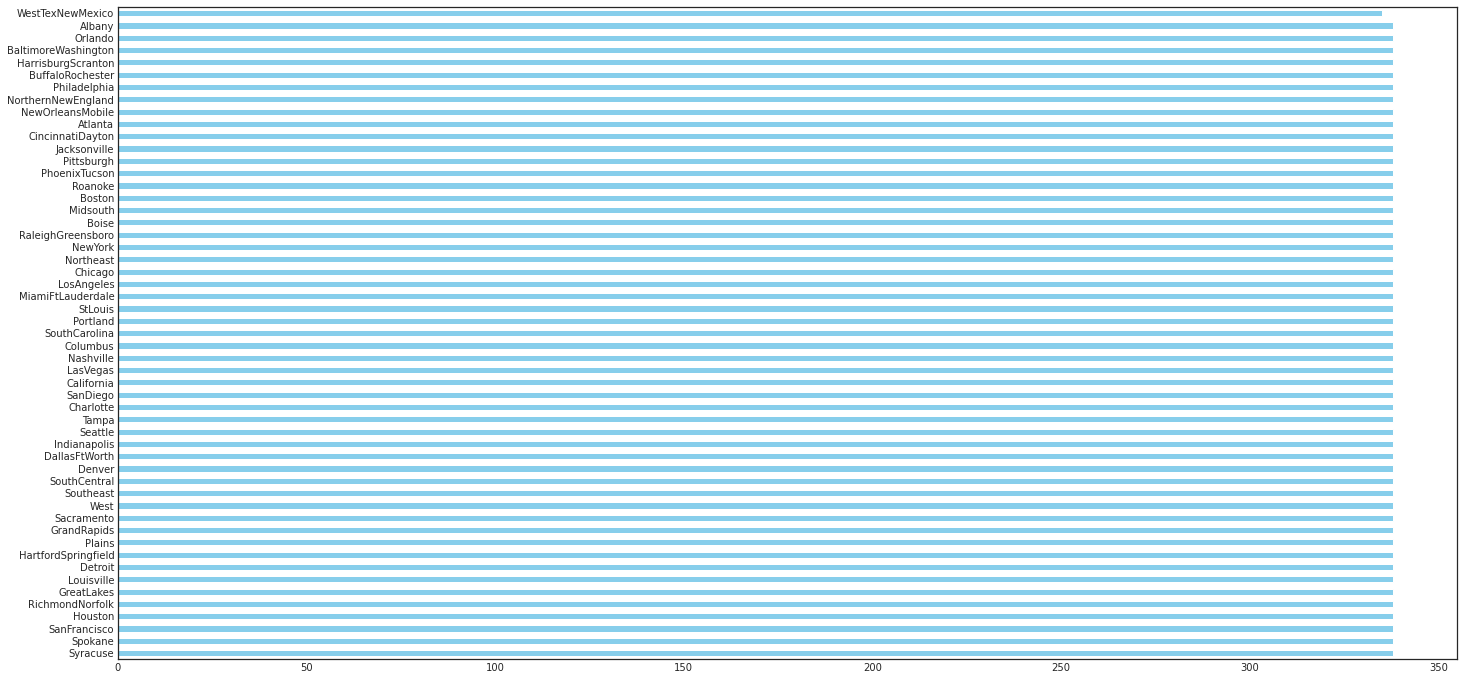

In [ ]:
plt.figure(figsize=(24,12))
df['region'].value_counts().plot(kind='barh', color='skyblue')

- The number of values for each region is almost the same as 338.
- We cannot identify unknown values for the region 'TotalUS' and we are going to drop it.

In [ ]:
# Drop certain values from region
df = df[df.region != 'TotalUS']

### Add columns - sale / month

In [ ]:
#Add Month column 
df['Month'] = df['Date'].str[5:7]
df['Month'] = df['Month'].astype('int32')
df.head()

Date  AveragePrice  Total Volume  ...  year  region  Month
0  2015-12-27          1.33      64236.62  ...  2015  Albany     12
1  2015-12-20          1.35      54876.98  ...  2015  Albany     12
2  2015-12-13          0.93     118220.22  ...  2015  Albany     12
3  2015-12-06          1.08      78992.15  ...  2015  Albany     12
4  2015-11-29          1.28      51039.60  ...  2015  Albany     11

[5 rows x 14 columns]

In [ ]:
#Add Sales column
df['Sales'] = df['Total Volume'].astype('int') * df['AveragePrice'].astype('float')
df.head()

Date  AveragePrice  Total Volume  ...  region  Month      Sales
0  2015-12-27          1.33      64236.62  ...  Albany     12   85433.88
1  2015-12-20          1.35      54876.98  ...  Albany     12   74082.60
2  2015-12-13          0.93     118220.22  ...  Albany     12  109944.60
3  2015-12-06          1.08      78992.15  ...  Albany     12   85311.36
4  2015-11-29          1.28      51039.60  ...  Albany     11   65329.92

[5 rows x 15 columns]

In [ ]:
# Convert 'Date' type to date
df['Date'] = pd.to_datetime(df['Date'])

range(1, 13)


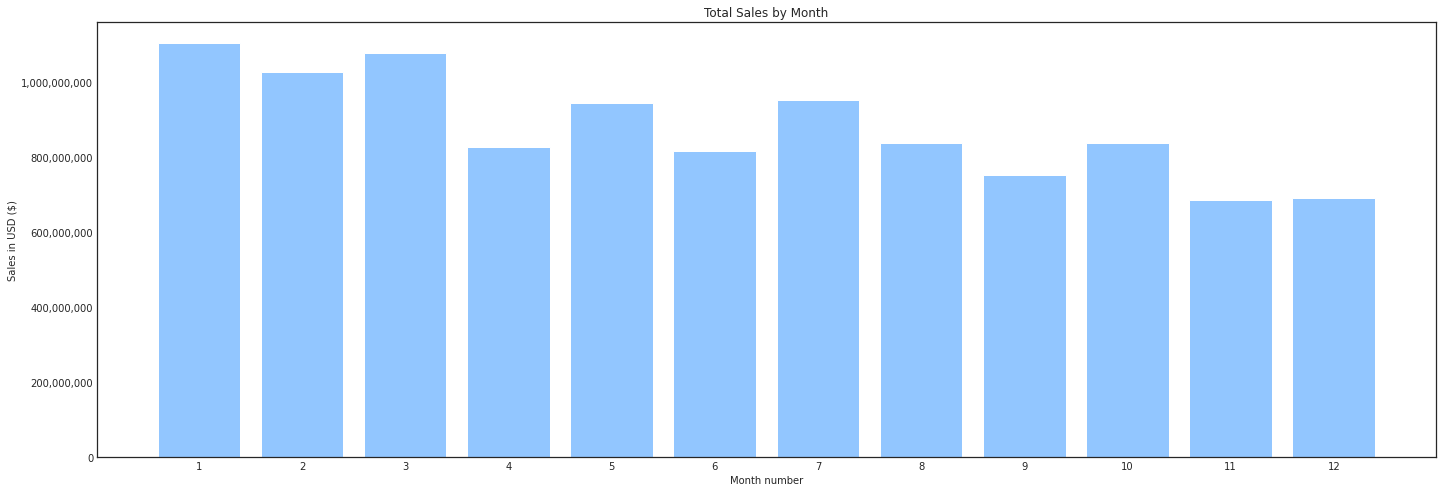

In [ ]:
#Plot the sales
months = range(1,13)
print(months)

plt.bar(months,df.groupby(['Month']).sum()['Sales'])
plt.xticks(months)
plt.title("Total Sales by Month")
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month number')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

In [ ]:
#Totals sales by region
sales = df.groupby(['region']).sum()
sales

AveragePrice  Total Volume  ...  Month         Sales
region                                           ...                     
Albany                     527.63  1.606780e+07  ...   2088  2.176647e+07
Atlanta                    452.23  8.860512e+07  ...   2088  9.379314e+07
BaltimoreWashington        518.57  1.347139e+08  ...   2088  1.799082e+08
Boise                      455.67  1.441319e+07  ...   2088  1.534645e+07
Boston                     517.44  9.727398e+07  ...   2088  1.265427e+08
BuffaloRochester           512.69  2.296247e+07  ...   2088  3.154484e+07
California                 471.62  1.028982e+09  ...   2088  1.121414e+09
Charlotte                  542.84  3.555554e+07  ...   2088  4.574278e+07
Chicago                    526.19  1.337023e+08  ...   2088  1.791103e+08
CincinnatiDayton           408.71  4.452201e+07  ...   2088  4.498938e+07
Columbus                   423.44  2.999336e+07  ...   2088  3.156273e+07
DallasFtWorth              366.93  2.084193e+08  ...   2088  1.756091e+08
Denver                     411.88  1.389025e+08  ...   2088  1.459826e+08
Detroit                    431.32  6.342242e+07  ...   2088  6.912603e+07
GrandRapids                508.69  3.021174e+07  ...   2088  3.785099e+07
GreatLakes                 452.43  5.896425e+08  ...   2088  6.886616e+08
HarrisburgScranton         511.49  4.180886e+07  ...   2088  5.295447e+07
HartfordSpringfield        614.70  5.067054e+07  ...   2088  7.118615e+07
Houston                    354.20  2.031679e+08  ...   2088  1.655712e+08
Indianapolis               444.13  3.026339e+07  ...   2088  3.402452e+07
Jacksonville               510.70  2.879000e+07  ...   2088  3.348370e+07
LasVegas                   466.75  5.437691e+07  ...   2088  5.480884e+07
LosAngeles                 411.01  5.078965e+08  ...   2088  4.842274e+08
Louisville                 434.90  1.609700e+07  ...   2088  1.749533e+07
MiamiFtLauderdale          482.83  9.767322e+07  ...   2088  1.185813e+08
Midsouth                   474.81  5.083494e+08  ...   2088  6.157236e+08
Nashville                  409.69  3.561209e+07  ...   2088  3.572644e+07
NewOrleansMobile           441.02  4.569514e+07  ...   2088  4.867606e+07
NewYork                    583.92  2.407341e+08  ...   2088  3.351953e+08
Northeast                  541.45  7.132809e+08  ...   2088  9.600076e+08
NorthernNewEngland         499.36  7.153289e+07  ...   2088  8.962500e+07
Orlando                    509.10  5.866070e+07  ...   2088  6.961094e+07
Philadelphia               551.66  7.183880e+07  ...   2088  9.981555e+07
PhoenixTucson              413.86  1.956433e+08  ...   2088  1.384513e+08
Pittsburgh                 461.14  1.880635e+07  ...   2088  2.319457e+07
Plains                     485.54  3.111885e+08  ...   2088  3.600364e+08
Portland                   445.39  1.105522e+08  ...   2088  1.128644e+08
RaleighGreensboro          525.63  4.820273e+07  ...   2088  5.983753e+07
RichmondNorfolk            436.47  4.223085e+07  ...   2088  4.734461e+07
Roanoke                    421.80  2.504201e+07  ...   2088  2.740907e+07
Sacramento                 548.09  7.516375e+07  ...   2088  9.480844e+07
SanDiego                   472.58  8.979192e+07  ...   2088  9.352686e+07
SanFrancisco               609.82  1.358302e+08  ...   2088  1.858338e+08
Seattle                    487.59  1.092142e+08  ...   2088  1.251789e+08
SouthCarolina              474.31  6.075377e+07  ...   2088  6.952785e+07
SouthCentral               372.22  1.011280e+09  ...   2088  8.740591e+08
Southeast                  472.53  6.152384e+08  ...   2088  7.036303e+08
Spokane                    488.61  1.556528e+07  ...   2088  1.715625e+07
StLouis                    483.55  3.207283e+07  ...   2088  3.743923e+07
Syracuse                   513.87  1.094267e+07  ...   2088  1.520494e+07
Tampa                      476.19  6.600454e+07  ...   2088  7.695882e+07
West                       430.01  1.086779e+09  ...   2088  1.066833e+09
WestTexNewMexico         

In [ ]:
#Top 10 sales by regions
sales10 = sales.nlargest(10, ['Sales']).reset_index()
sales10.head(10)
# sales10_final = sales10[region]

region  AveragePrice  Total Volume  ...    year  Month         Sales
0    California        471.62  1.028982e+09  ...  681458   2088  1.121414e+09
1          West        430.01  1.086779e+09  ...  681458   2088  1.066833e+09
2     Northeast        541.45  7.132809e+08  ...  681458   2088  9.600076e+08
3  SouthCentral        372.22  1.011280e+09  ...  681458   2088  8.740591e+08
4     Southeast        472.53  6.152384e+08  ...  681458   2088  7.036303e+08
5    GreatLakes        452.43  5.896425e+08  ...  681458   2088  6.886616e+08
6      Midsouth        474.81  5.083494e+08  ...  681458   2088  6.157236e+08
7    LosAngeles        411.01  5.078965e+08  ...  681458   2088  4.842274e+08
8        Plains        485.54  3.111885e+08  ...  681458   2088  3.600364e+08
9       NewYork        583.92  2.407341e+08  ...  681458   2088  3.351953e+08

[10 rows x 13 columns]

[Text(0, 0, '0'),
 Text(0, 0, '200,000,000'),
 Text(0, 0, '400,000,000'),
 Text(0, 0, '600,000,000'),
 Text(0, 0, '800,000,000'),
 Text(0, 0, '1,000,000,000'),
 Text(0, 0, '1,200,000,000')]

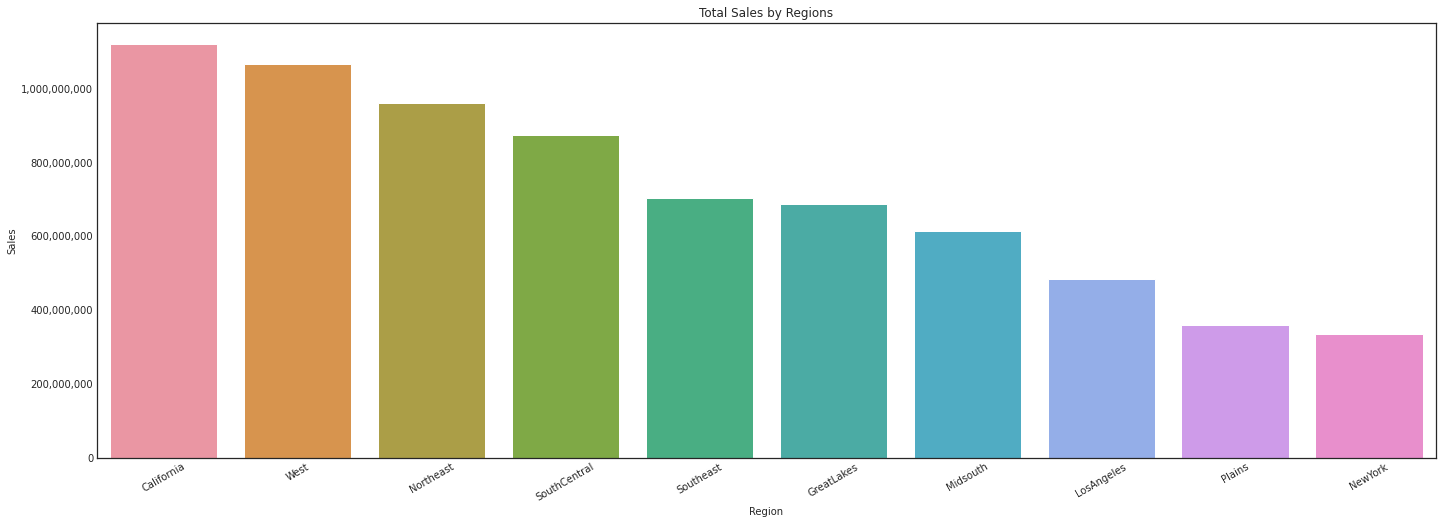

In [ ]:
#Plot the sales by regions
sns.barplot(x='region', y='Sales', data = sales10)
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Total Sales by Regions")
plt.xlabel("Region")
plt.ylabel("Sales")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

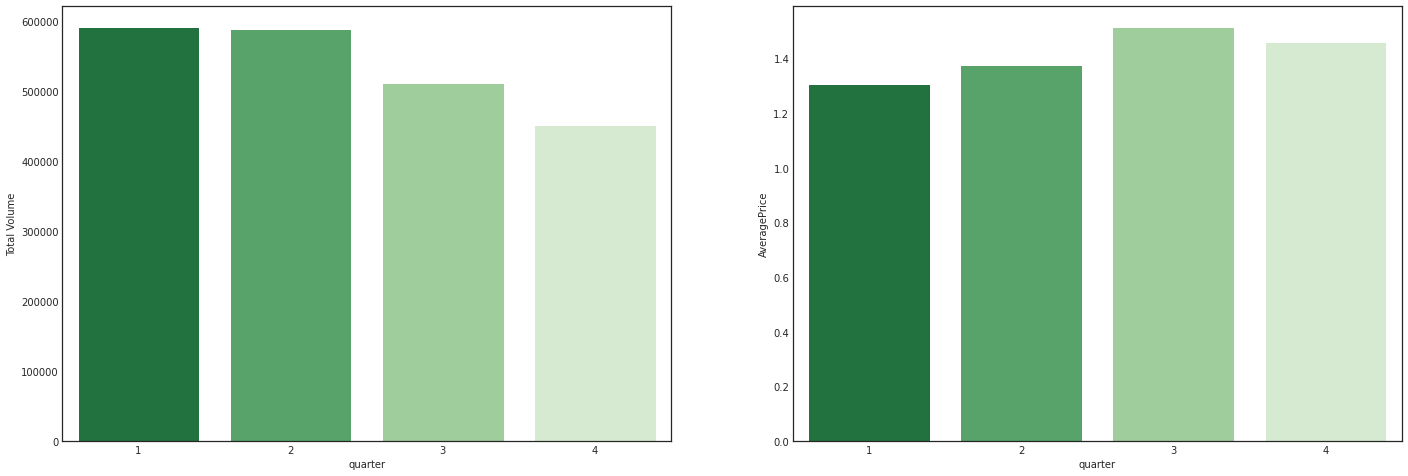

Total Volume  AveragePrice
quarter                             
1        591376.398607      1.308230
2        588510.610317      1.376745
3        512057.977472      1.514932
4        451311.177172      1.459811

In [ ]:
#Average price by quarter
fig, ax = plt.subplots(1, 2, figsize=(24,8))

df['quarter'] = df['Date'].dt.quarter

sns.barplot(x='quarter', y='Total Volume', data=df, palette='Greens_r', ci=None, ax=ax[0])
sns.barplot(x='quarter', y='AveragePrice', data=df, palette='Greens_r', ci=None, ax=ax[1])

plt.show()

quarter = df.groupby('quarter')[['Total Volume', 'AveragePrice']].mean()
display(quarter)

[Text(0, 0, '0'),
 Text(0, 0, '200,000,000'),
 Text(0, 0, '400,000,000'),
 Text(0, 0, '600,000,000'),
 Text(0, 0, '800,000,000'),
 Text(0, 0, '1,000,000,000'),
 Text(0, 0, '1,200,000,000')]

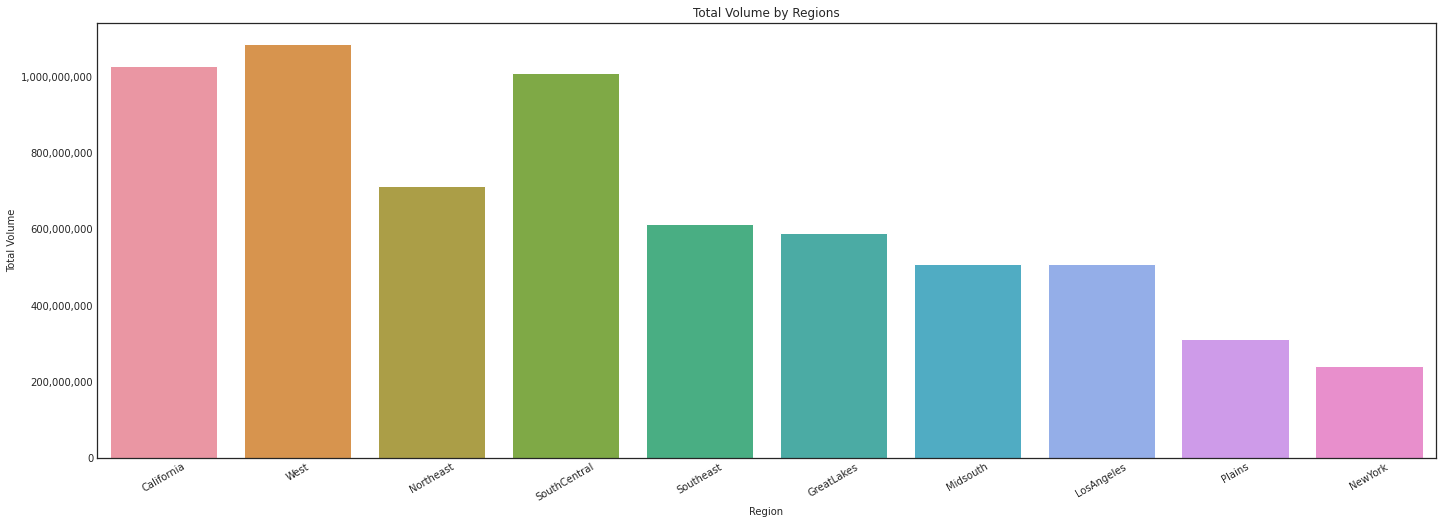

In [ ]:
#Plot the volume by total regions
sns.barplot(x='region', y='Total Volume', data = sales10)
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Total Volume by Regions")
plt.xlabel("Region")
plt.ylabel("Total Volume")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

In [ ]:
#Total sales by year
year = df.groupby(['year']).sum().reset_index()

[Text(0, 0, '0'),
 Text(0, 0, '500,000,000'),
 Text(0, 0, '1,000,000,000'),
 Text(0, 0, '1,500,000,000'),
 Text(0, 0, '2,000,000,000'),
 Text(0, 0, '2,500,000,000'),
 Text(0, 0, '3,000,000,000'),
 Text(0, 0, '3,500,000,000'),
 Text(0, 0, '4,000,000,000')]

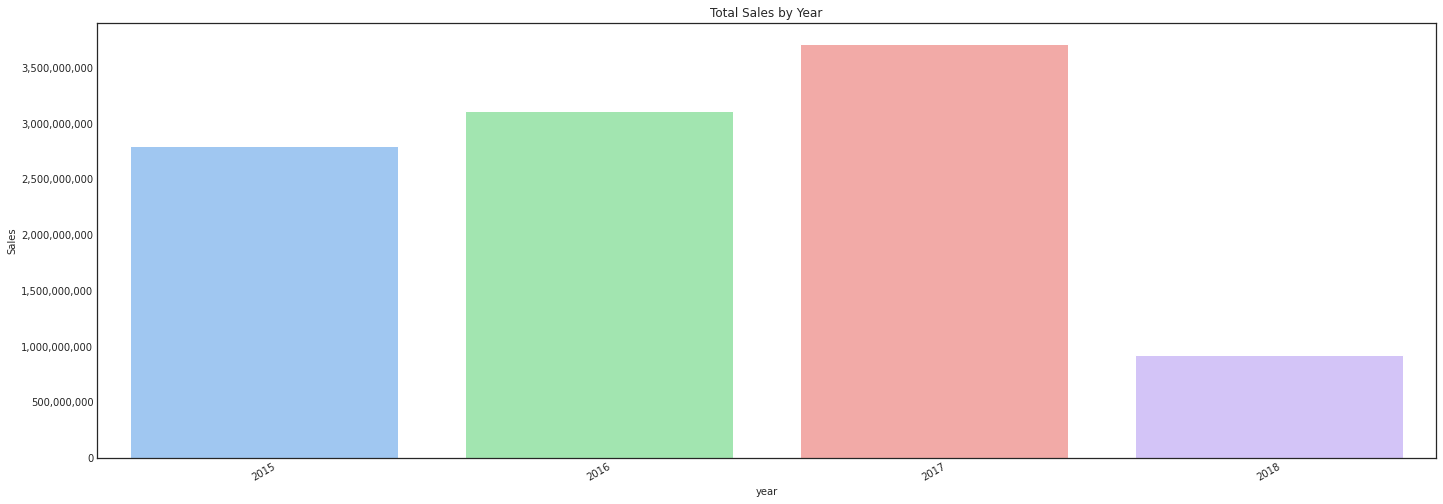

In [ ]:
#Plot the sales by year
sns.barplot(x='year', y='Sales', data = year)
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Total Sales by Year")
plt.xlabel("year")
plt.ylabel("Sales")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

[Text(0, 0, '0'),
 Text(0, 0, '500,000,000'),
 Text(0, 0, '1,000,000,000'),
 Text(0, 0, '1,500,000,000'),
 Text(0, 0, '2,000,000,000'),
 Text(0, 0, '2,500,000,000'),
 Text(0, 0, '3,000,000,000'),
 Text(0, 0, '3,500,000,000'),
 Text(0, 0, '4,000,000,000')]

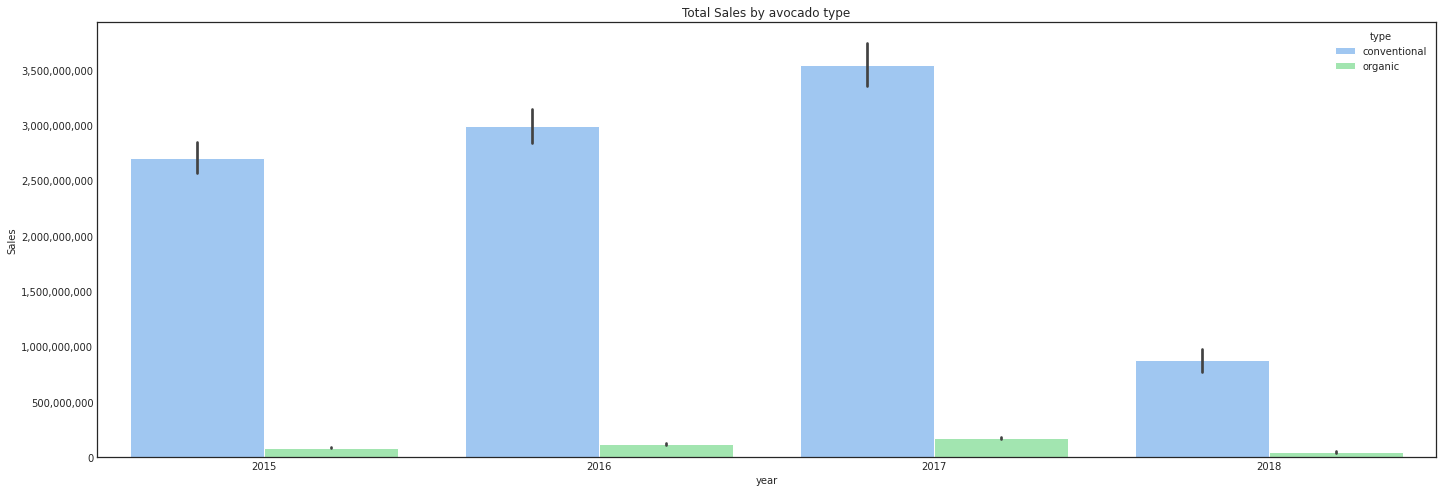

In [ ]:
# Total Sales by type and year
sns.barplot(x='year', y='Sales', hue='type', estimator = sum, data=df)
plt.title("Total Sales by avocado type")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])

## Description of Numerical Data

In [ ]:
df.describe()

AveragePrice  Total Volume  ...         Sales       quarter
count  17911.000000  1.791100e+04  ...  1.791100e+04  17911.000000
mean       1.407619  5.392587e+05  ...  5.888295e+05      2.402323
std        0.404253  1.224332e+06  ...  1.271979e+06      1.147835
min        0.440000  8.456000e+01  ...  1.335600e+02      1.000000
25%        1.100000  1.057102e+04  ...  1.673481e+04      1.000000
50%        1.370000  1.001541e+05  ...  1.308600e+05      2.000000
75%        1.670000  4.001767e+05  ...  4.762899e+05      3.000000
max        3.250000  1.127475e+07  ...  9.160553e+06      4.000000

[8 rows x 13 columns]

- Mean of Average Price is 1.40. 50% of avocados are sold below 1.37 and 75% of avocados are sold below 1.67.

In [ ]:
# Identify correlation between variables
df.corr()

AveragePrice  Total Volume  ...     Sales   quarter
AveragePrice      1.000000     -0.343982  ... -0.283349  0.171279
Total Volume     -0.343982      1.000000  ...  0.970054 -0.045286
4046             -0.342105      0.895002  ...  0.820301 -0.041366
4225             -0.267643      0.872547  ...  0.895239 -0.037385
4770             -0.241213      0.649072  ...  0.621987 -0.046660
Total Bags       -0.307685      0.924980  ...  0.905452 -0.041036
Small Bags       -0.296151      0.920763  ...  0.908251 -0.041627
Large Bags       -0.248909      0.668446  ...  0.634457 -0.028106
XLarge Bags      -0.154424      0.538396  ...  0.567843 -0.018968
year              0.091897      0.030621  ...  0.056398 -0.175736
Month             0.161463     -0.043859  ... -0.018959  0.972903
Sales            -0.283349      0.970054  ...  1.000000 -0.018571
quarter           0.171279     -0.045286  ... -0.018571  1.000000

[13 rows x 13 columns]

- As we mentioned above, column PLU 4046, 4225, 4770, Small Bags, Large Bags, XLarge Bags .. DROP IT OR NOW?! check later.

Text(0.5, 1.0, 'Correlation Heatmap')

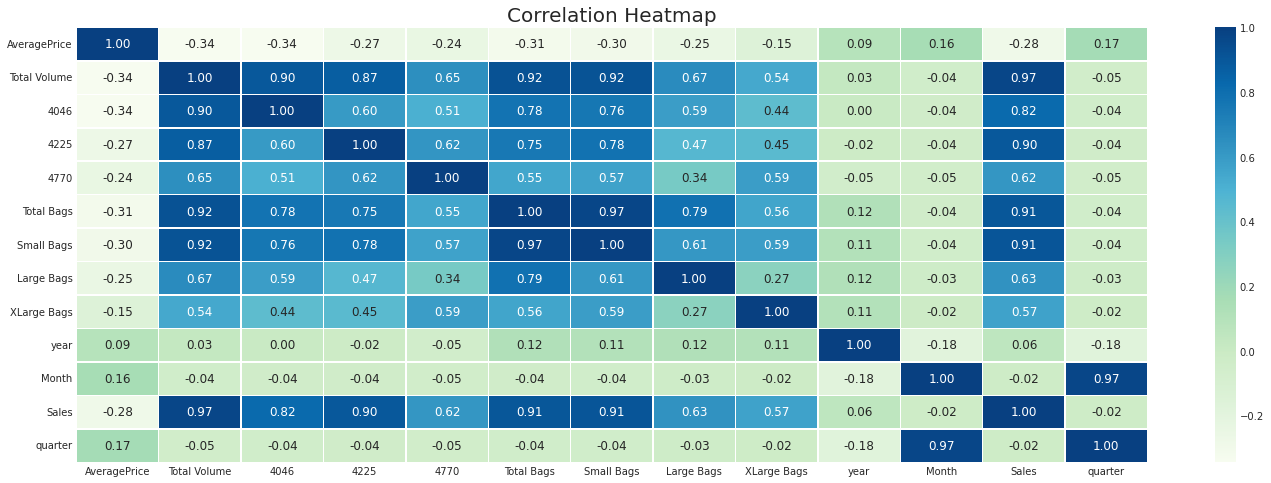

In [ ]:
# Check the correlation between features
corr = df.corr() 
f,ax = plt.subplots()
sns.heatmap(corr, annot = True, annot_kws={"size":12}, fmt= '.2f', 
            xticklabels= True, yticklabels= True
            ,cmap="GnBu", linewidths=.5, ax=ax)
plt.title('Correlation Heatmap', size=20)

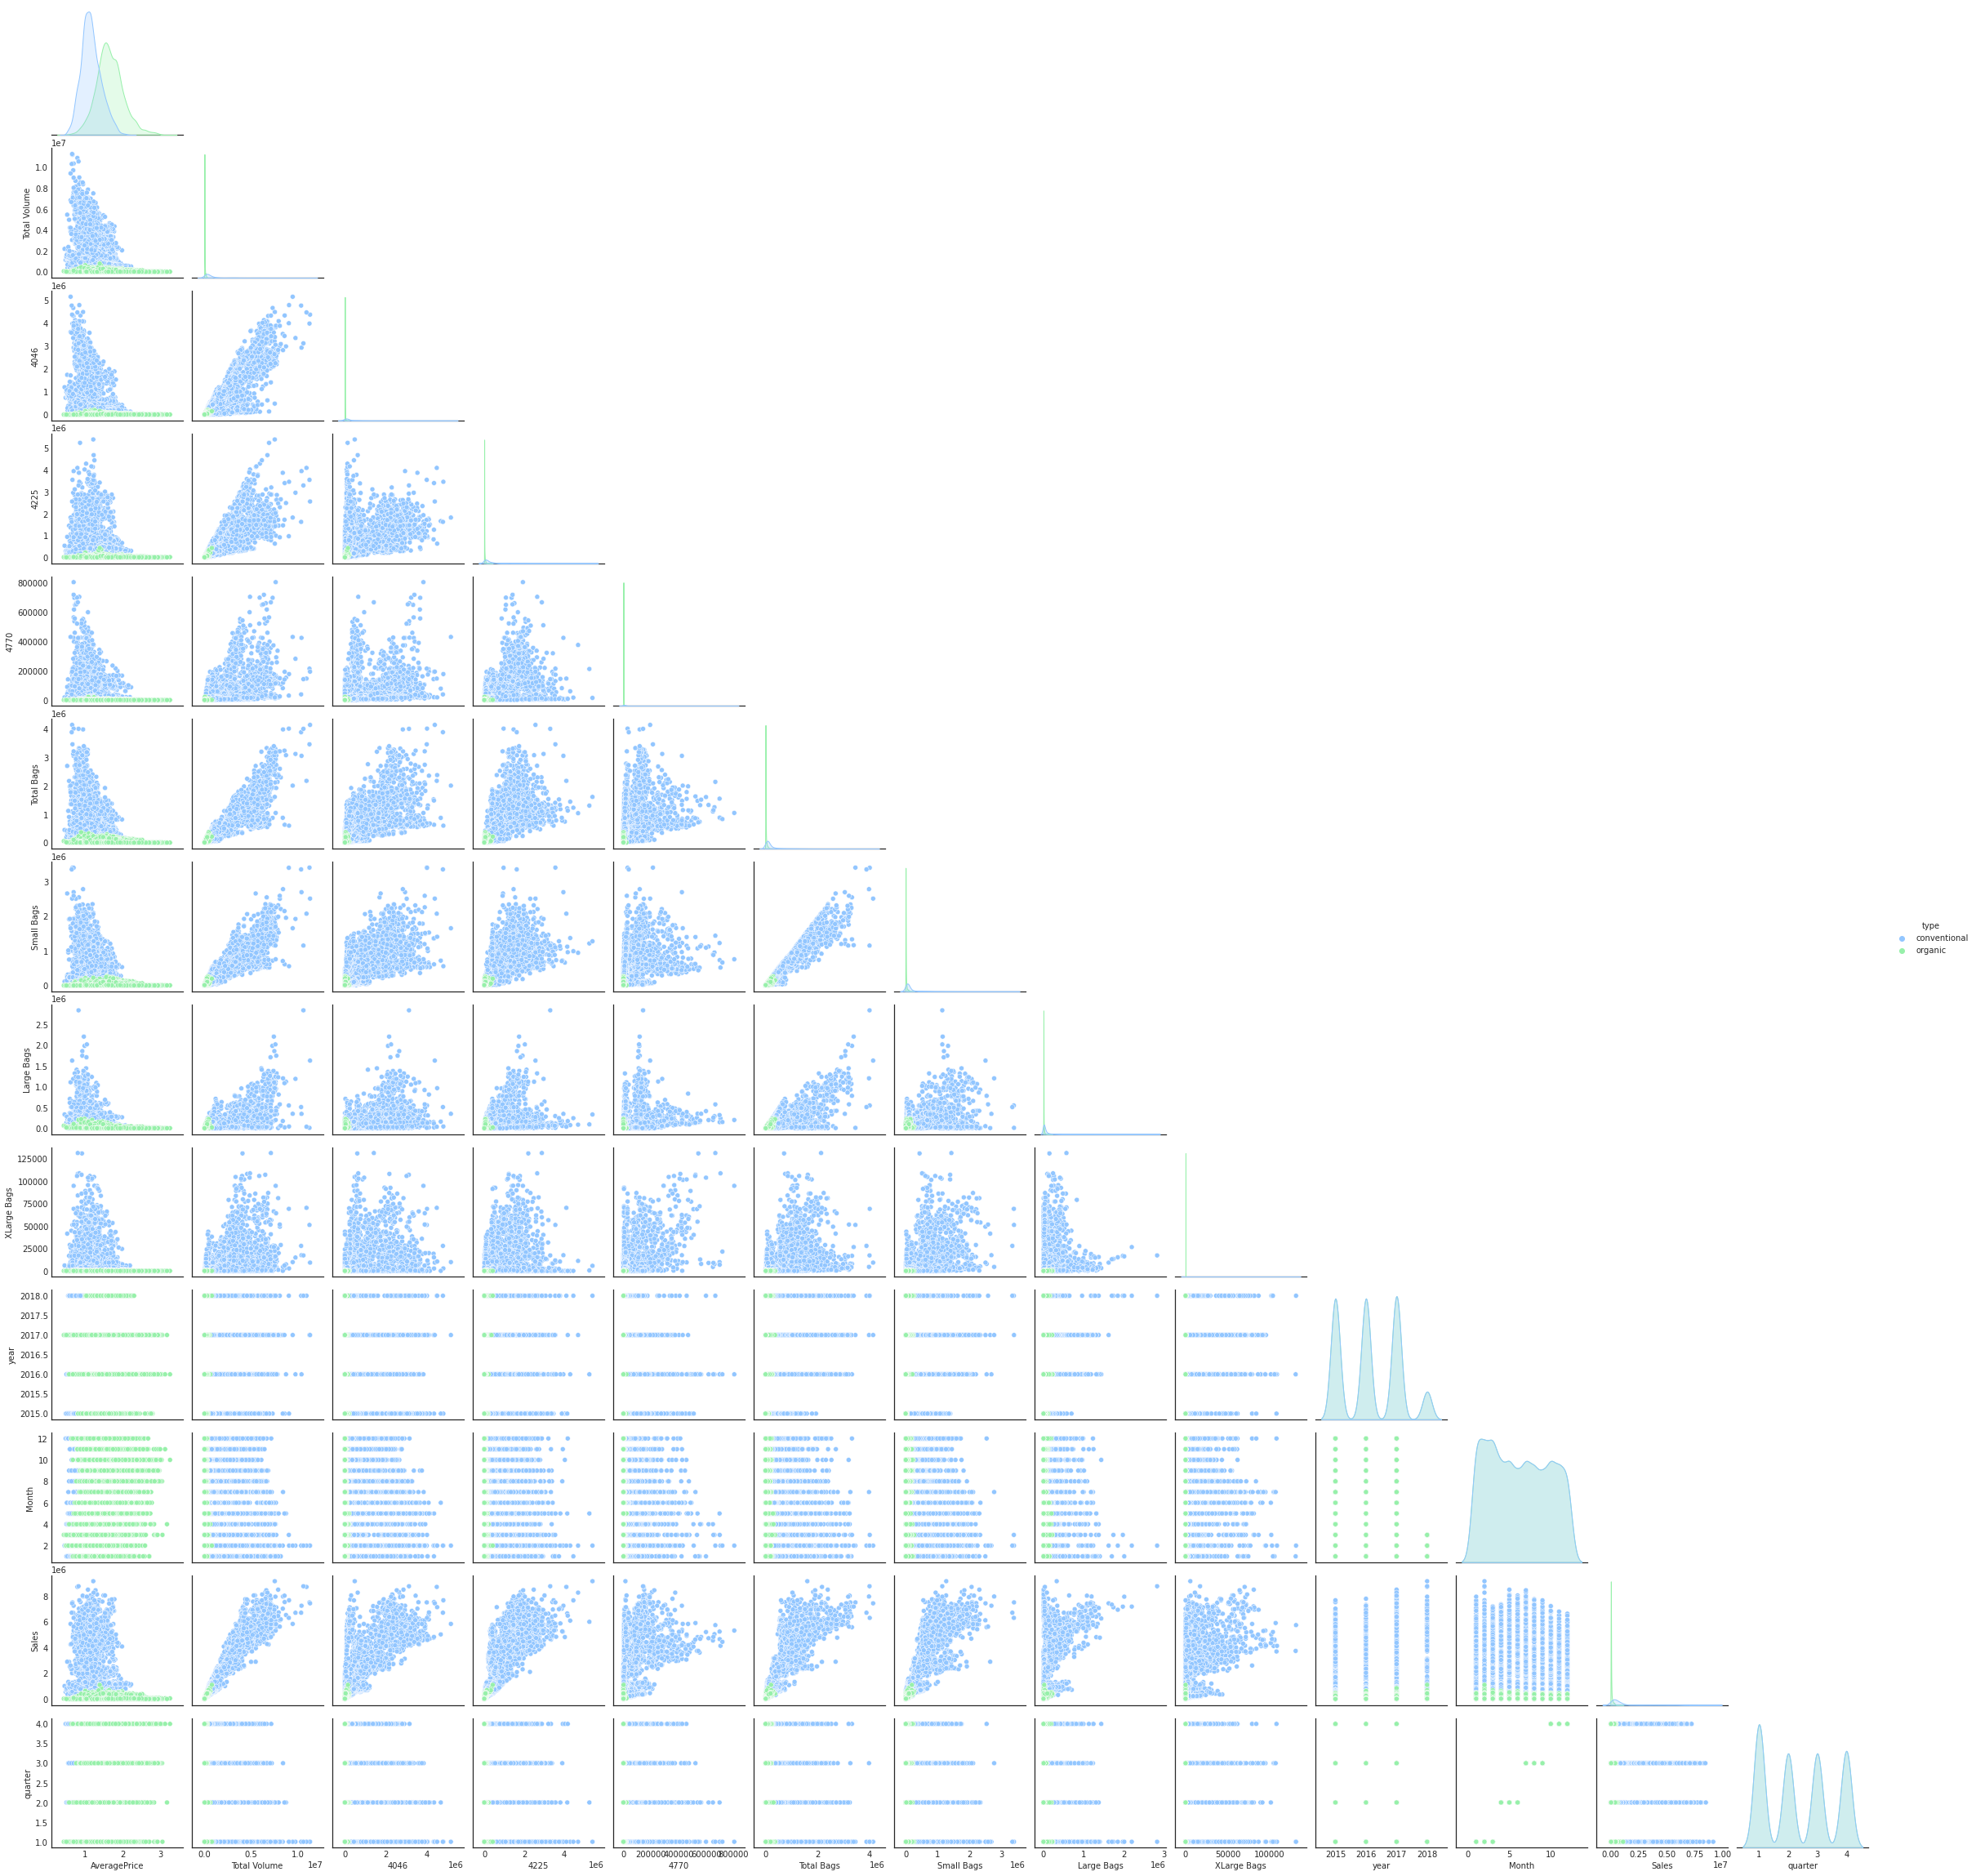

In [ ]:
# Pairplot
sns.pairplot(df, hue="type", corner=True)
'''g = sns.PairGrid(df, hue="type")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()'''

In [ ]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'Month', 'Sales', 'quarter'],
      dtype='object')

## Average Price Trend

In [ ]:
df_type = df.groupby(by=["type"]).mean().reset_index()
df_type

type  AveragePrice  Total Volume  ...     Month         Sales   quarter
0  conventional      1.159285  1.047895e+06  ...  6.177515  1.129729e+06  2.402367
1       organic      1.656036  3.045154e+04  ...  6.176904  4.774892e+04  2.402278

[2 rows x 14 columns]

Text(0.5, 1.0, 'Average Price over year')

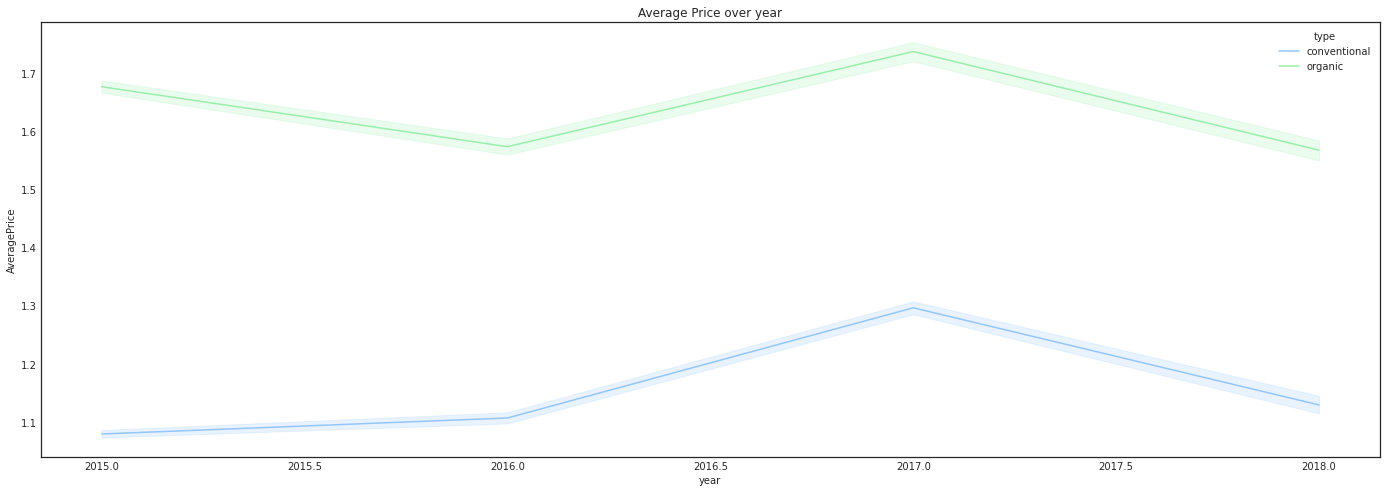

In [ ]:
# Check average price trend by type
sns.lineplot(data=df, x="year", y="AveragePrice", hue='type').set_title("Average Price over year")
# hue="month"

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


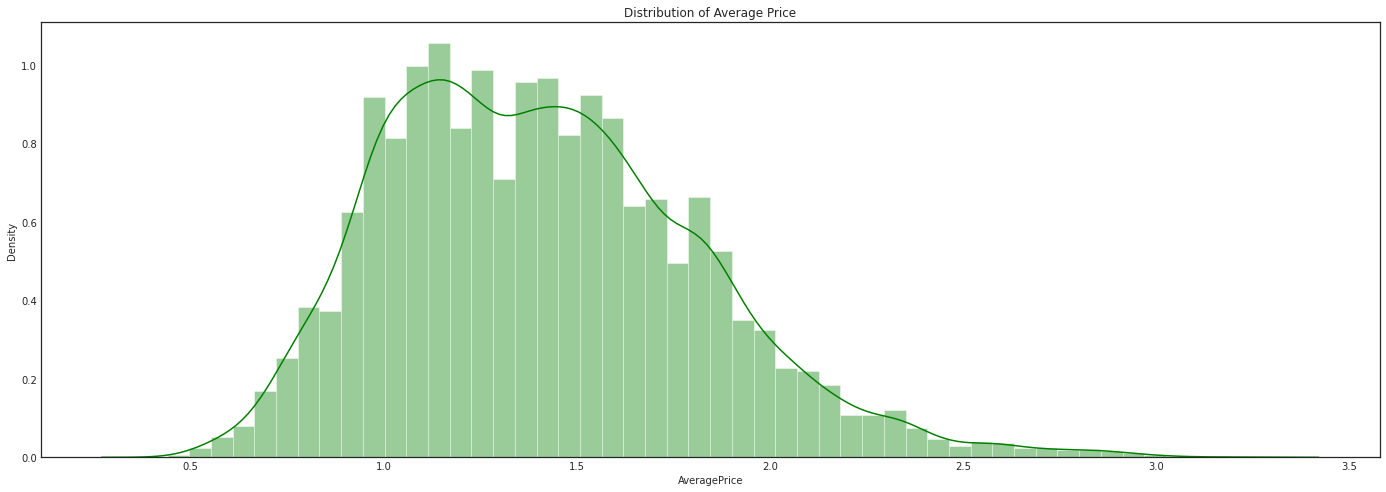

In [ ]:
# understand distribution of average price
plt.title("Distribution of Average Price")
sns.distplot(df["AveragePrice"], color = 'g')

- Average price of avocado is mostly distributed between 1.0 ~ 1.5.
- The distribution of average price is slightly right-skewed.

<Figure size 1728x864 with 0 Axes>

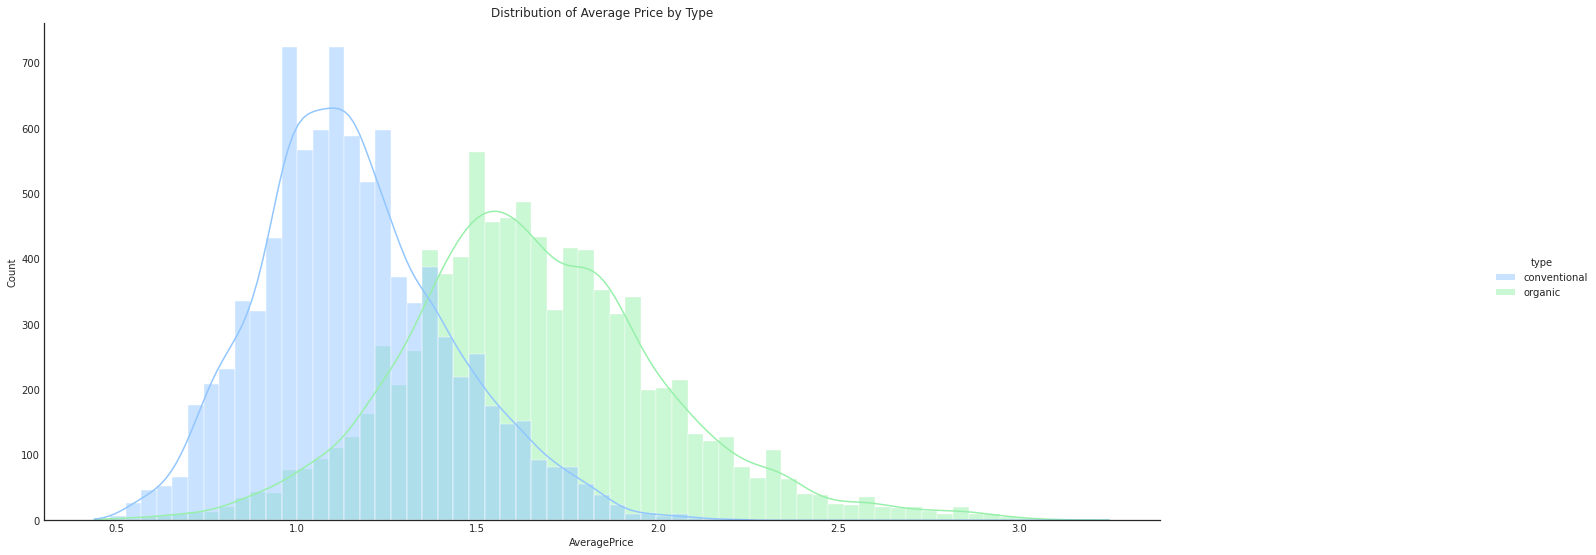

In [ ]:
# understand distribution of average price by type
pl = sns.displot(data=df, x="AveragePrice", hue="type", kde=True)
plt.title("Distribution of Average Price by Type")
pl.fig.set_size_inches(24,8)

Text(0.5, 1.0, 'Average Price by Type')

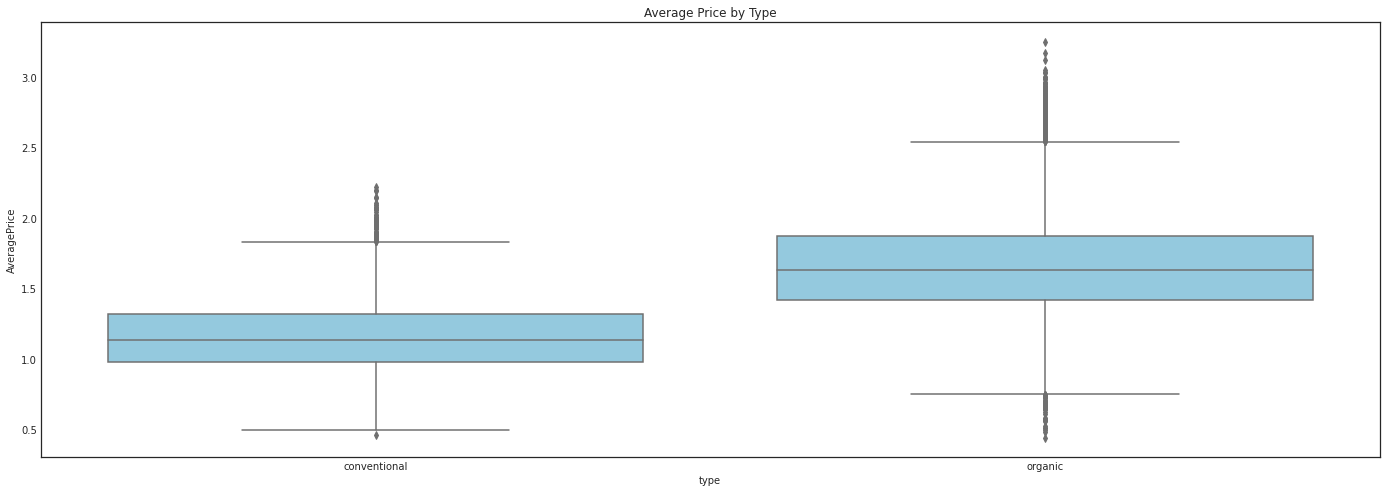

In [ ]:
# Create boxplot for type
sns.boxplot(y= "AveragePrice", x= "type", data=df, color = 'skyblue').set_title("Average Price by Type")

- Average price of organic avocado is higher than conventional avocado.
- Average price of conventional avocado is between 1.0 ~ 1.4 and organic is between 1.5 ~ 2.0.

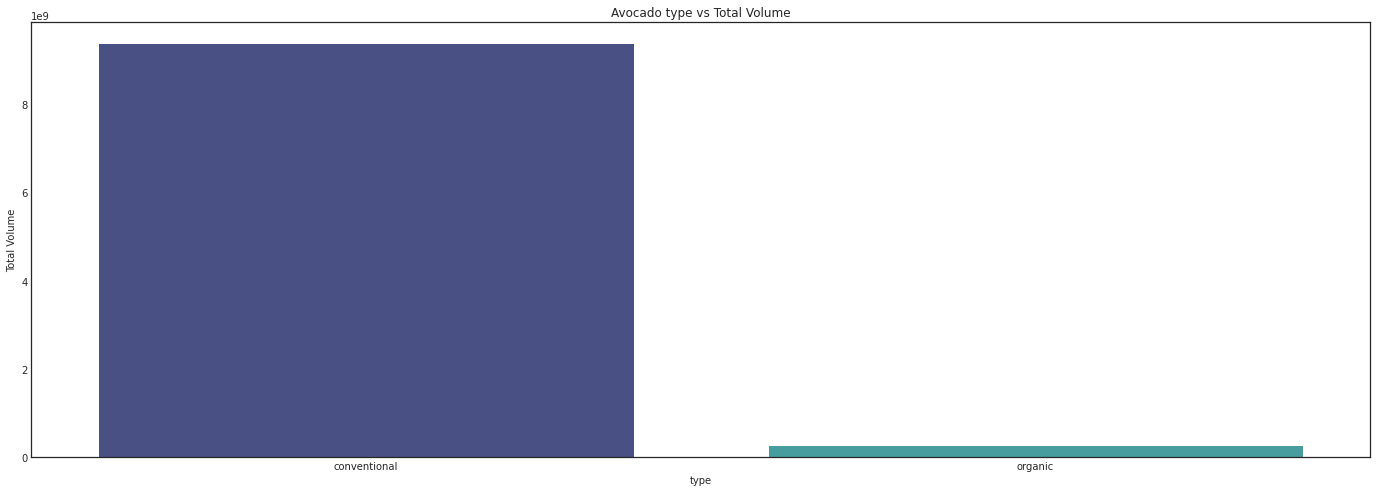

In [ ]:
# Create barplot of type of avacados and volume
fig, ax = plt.subplots(figsize=(24,8))
sns.barplot(x='type', y='Total Volume', data=df, palette='mako', ax=ax, estimator=sum, ci=None)
ax.set_title('Avocado type vs Total Volume')
plt.show()

# Build model to predict the price

## Preprocessing features

In [ ]:
## Scale categorical features
# Define the map function
def dummies(x, df):
    dum = pd.get_dummies(df[x], prefix=x, drop_first = True)
    df = pd.concat([df, dum], axis = 1)
    df.drop([x], axis = 1, inplace = True)
    return df

# Run above function to df
df = dummies('type', df)

# print
print(df.shape)
display(df.head(3))

(17911, 16)


Date  AveragePrice  Total Volume  ...      Sales  quarter  type_organic
0 2015-12-27          1.33      64236.62  ...   85433.88        4             0
1 2015-12-20          1.35      54876.98  ...   74082.60        4             0
2 2015-12-13          0.93     118220.22  ...  109944.60        4             0

[3 rows x 16 columns]

In [ ]:
# Set x, y to predict
y = df.AveragePrice
X = df.drop(['AveragePrice', 'Date', 'region'], axis=1)

# Split the data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
# Standardize X_train and X_test(independant variable) using standard scaler
ss = StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

In [ ]:
# Build the model

def regression_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = metrics.mean_squared_error(y_test, y_pred) 
    r2 = metrics.r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    
    print("Model: ", name)
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('R2: ', round(r2,4))
    print('Adjusted_r2: ', round(adjusted_r2,4))

# Regression

## Linear Regression

In [ ]:
# Linear Regression
model = LinearRegression()
regression_model(model, "Linear Regression")

Model:  Linear Regression
MSE:  0.0846
RMSE:  0.2909
R2:  0.4758
Adjusted_r2:  0.4746


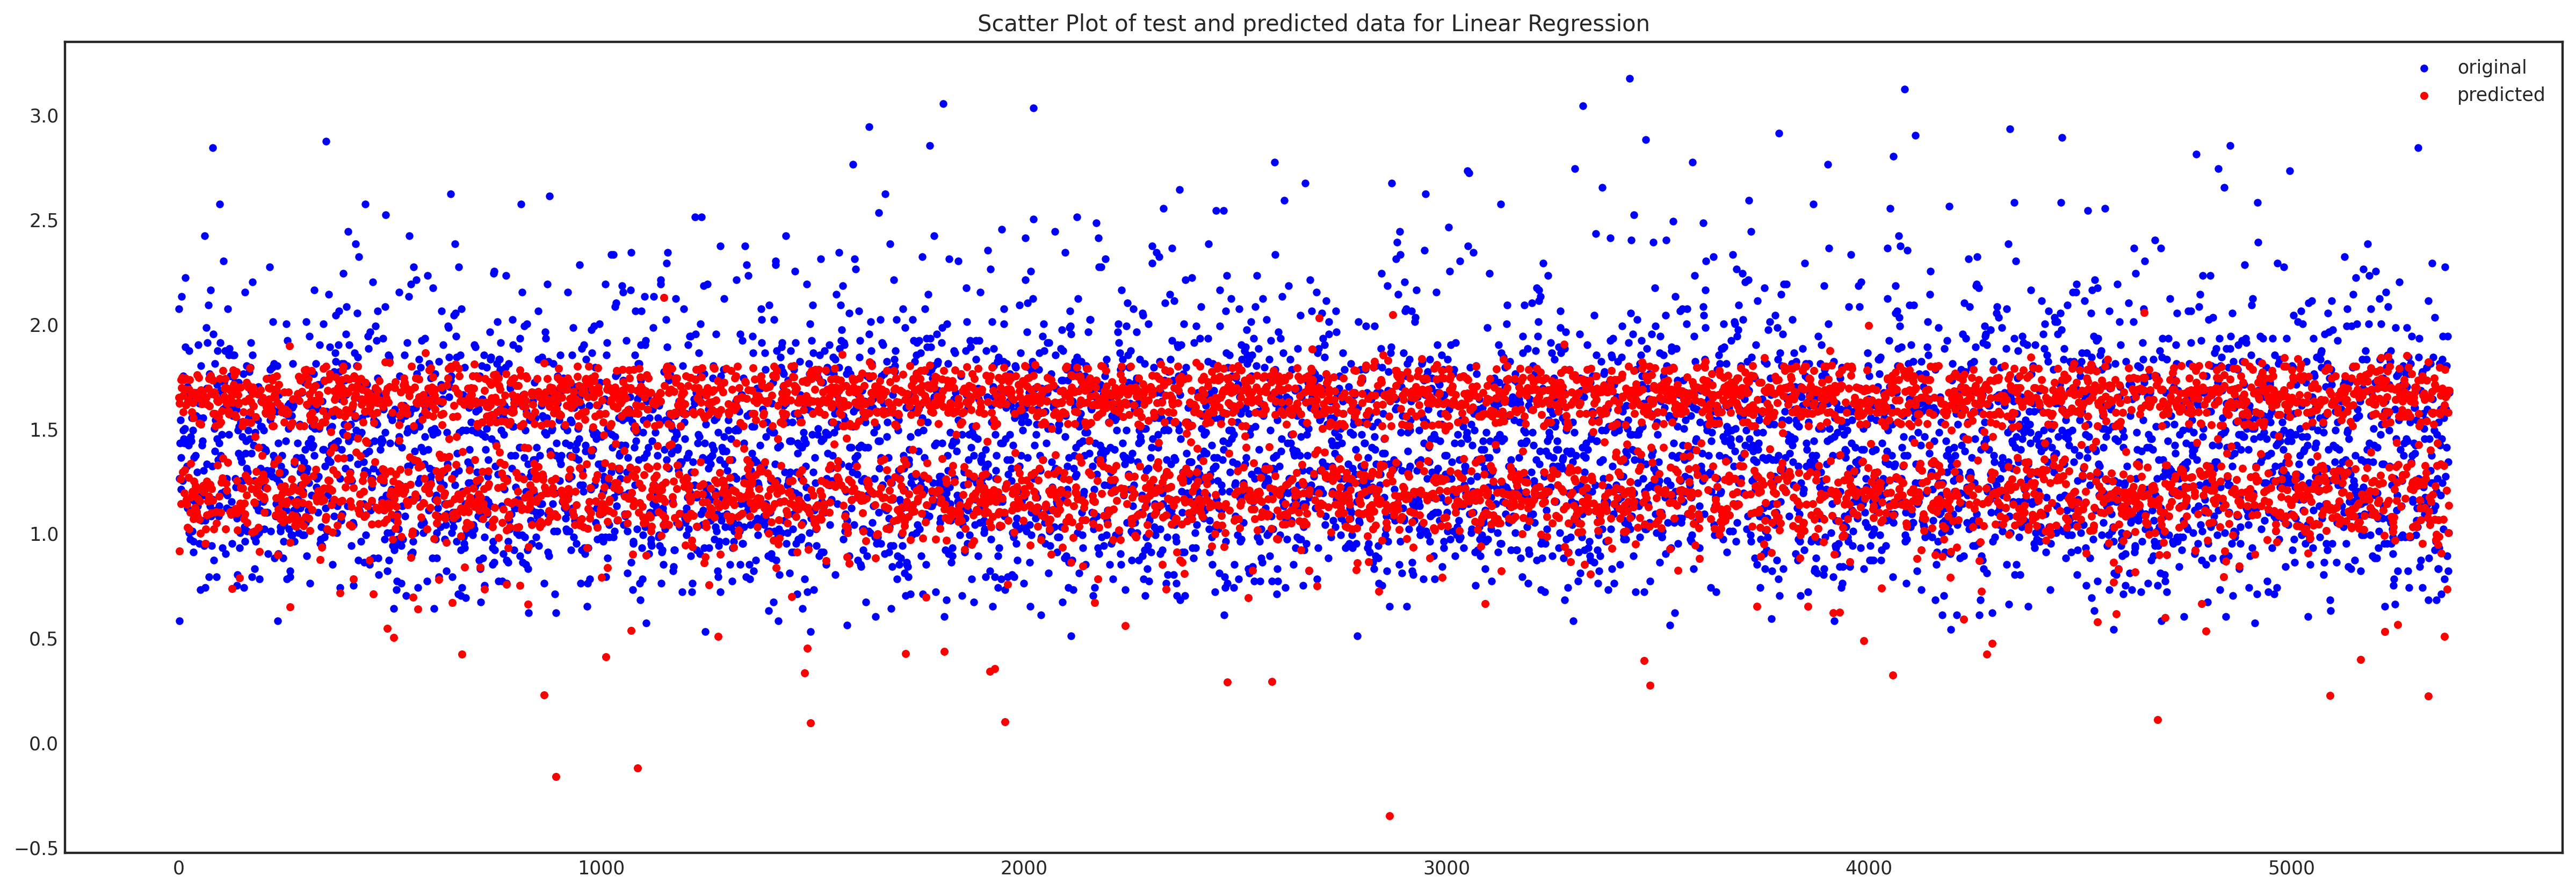

In [ ]:
# Scatter plot for linear regression
plt.figure(figsize=(24, 8), dpi=250)
y_pred = model.predict(X_test)
plt.scatter(range(len(y_test)), y_test, color="blue", s=10, label="original")
plt.scatter(range(len(y_test)), y_pred, color="red", s=11, label="predicted")
plt.title("Scatter Plot of test and predicted data for Linear Regression")
plt.legend()
plt.show()

## Decision Tree Regression

In [ ]:
# Decision Tree Regression
model = DecisionTreeRegressor()
regression_model(model, "Decision Tree Regressor")

Model:  Decision Tree Regressor
MSE:  0.0363
RMSE:  0.1905
R2:  0.7752
Adjusted_r2:  0.7746


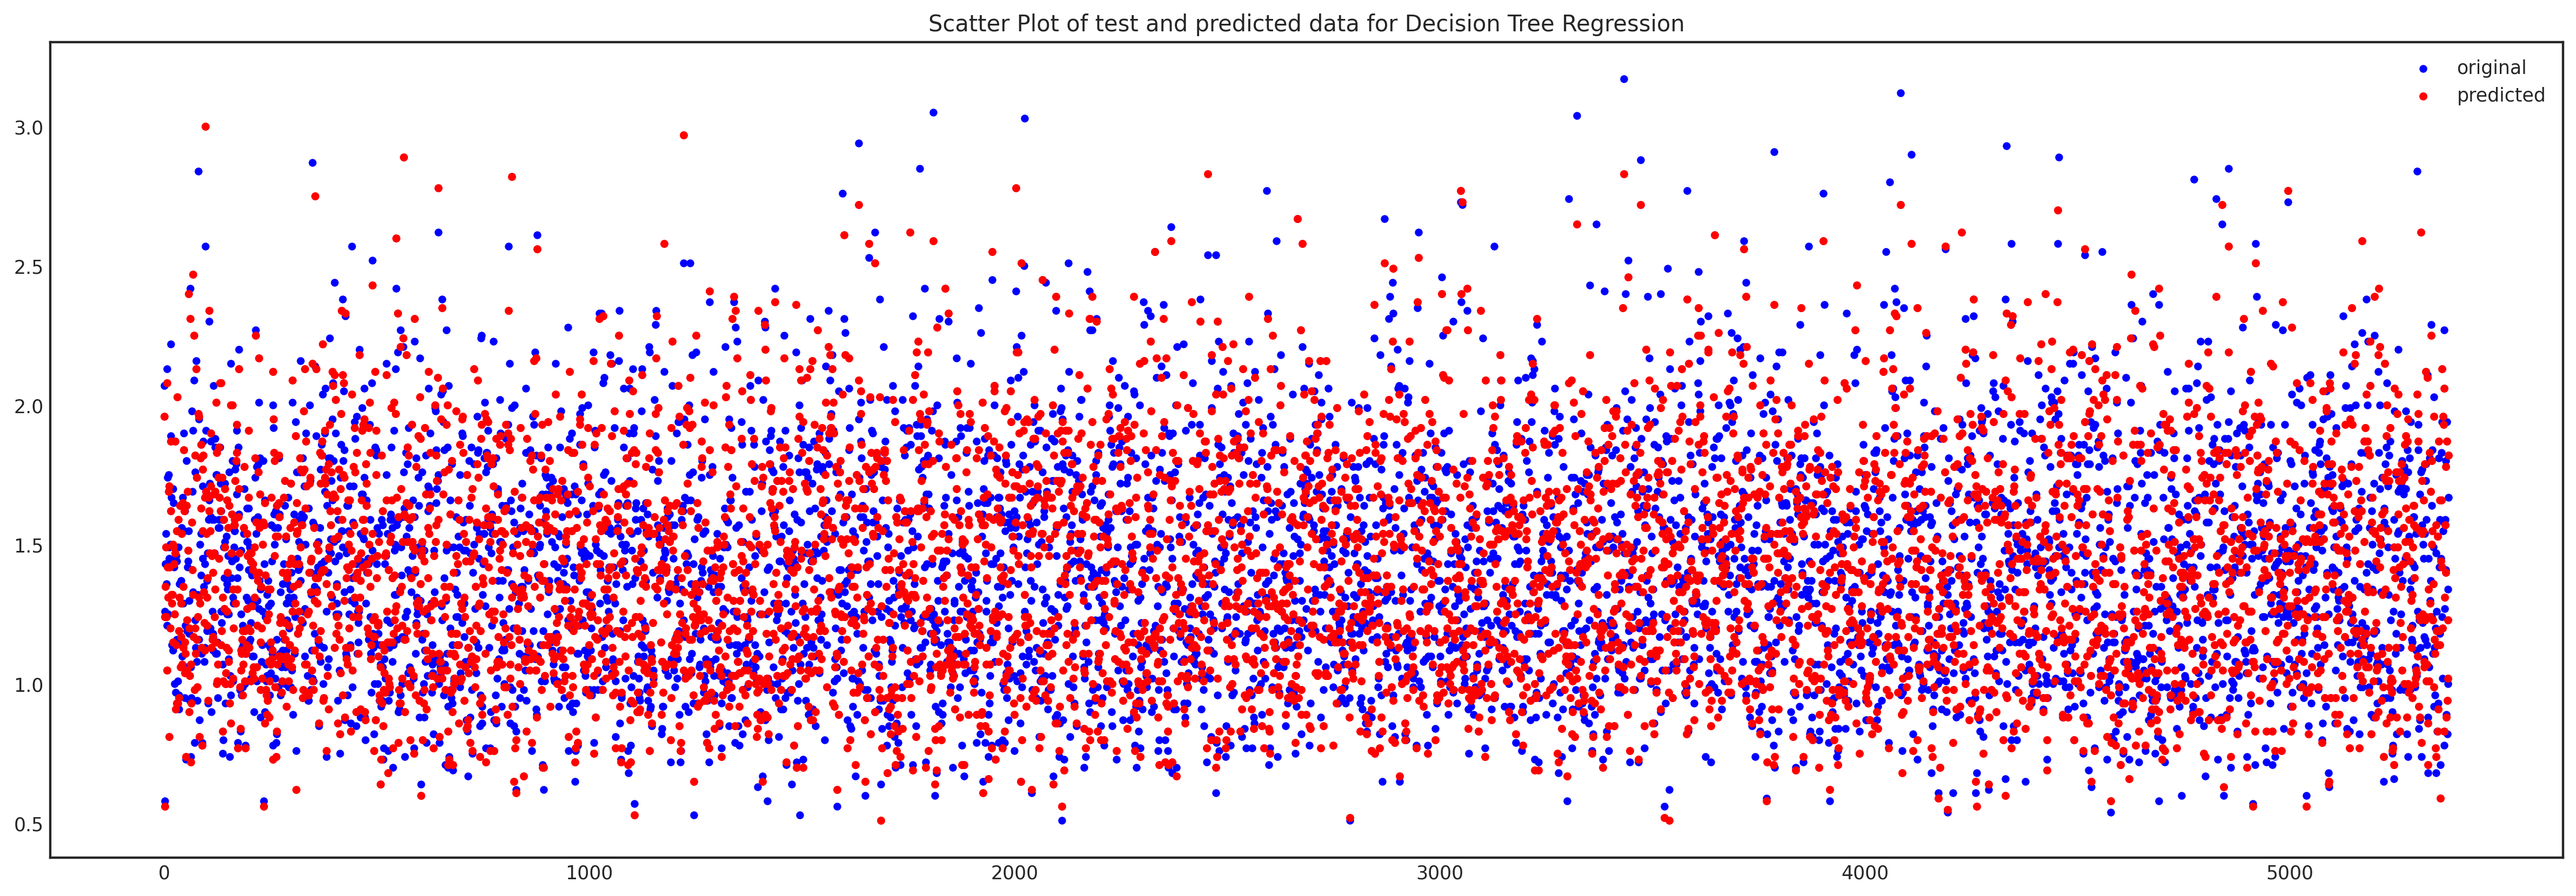

In [ ]:
# Scatter plot for decision tree regression
plt.figure(figsize=(24, 8), dpi=250)
y_pred = model.predict(X_test)
plt.scatter(range(len(y_test)), y_test, color="blue", s=10, label="original")
plt.scatter(range(len(y_test)), y_pred, color="red", s=11, label="predicted")
plt.title("Scatter Plot of test and predicted data for Decision Tree Regression")
plt.legend()
plt.show()

## XGB Regression

In [ ]:
# XGB Regression
model = XGBRegressor()
regression_model(model, "XGB Regressor")

[18:57:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model:  XGB Regressor
MSE:  0.0319
RMSE:  0.1786
R2:  0.8025
Adjusted_r2:  0.802


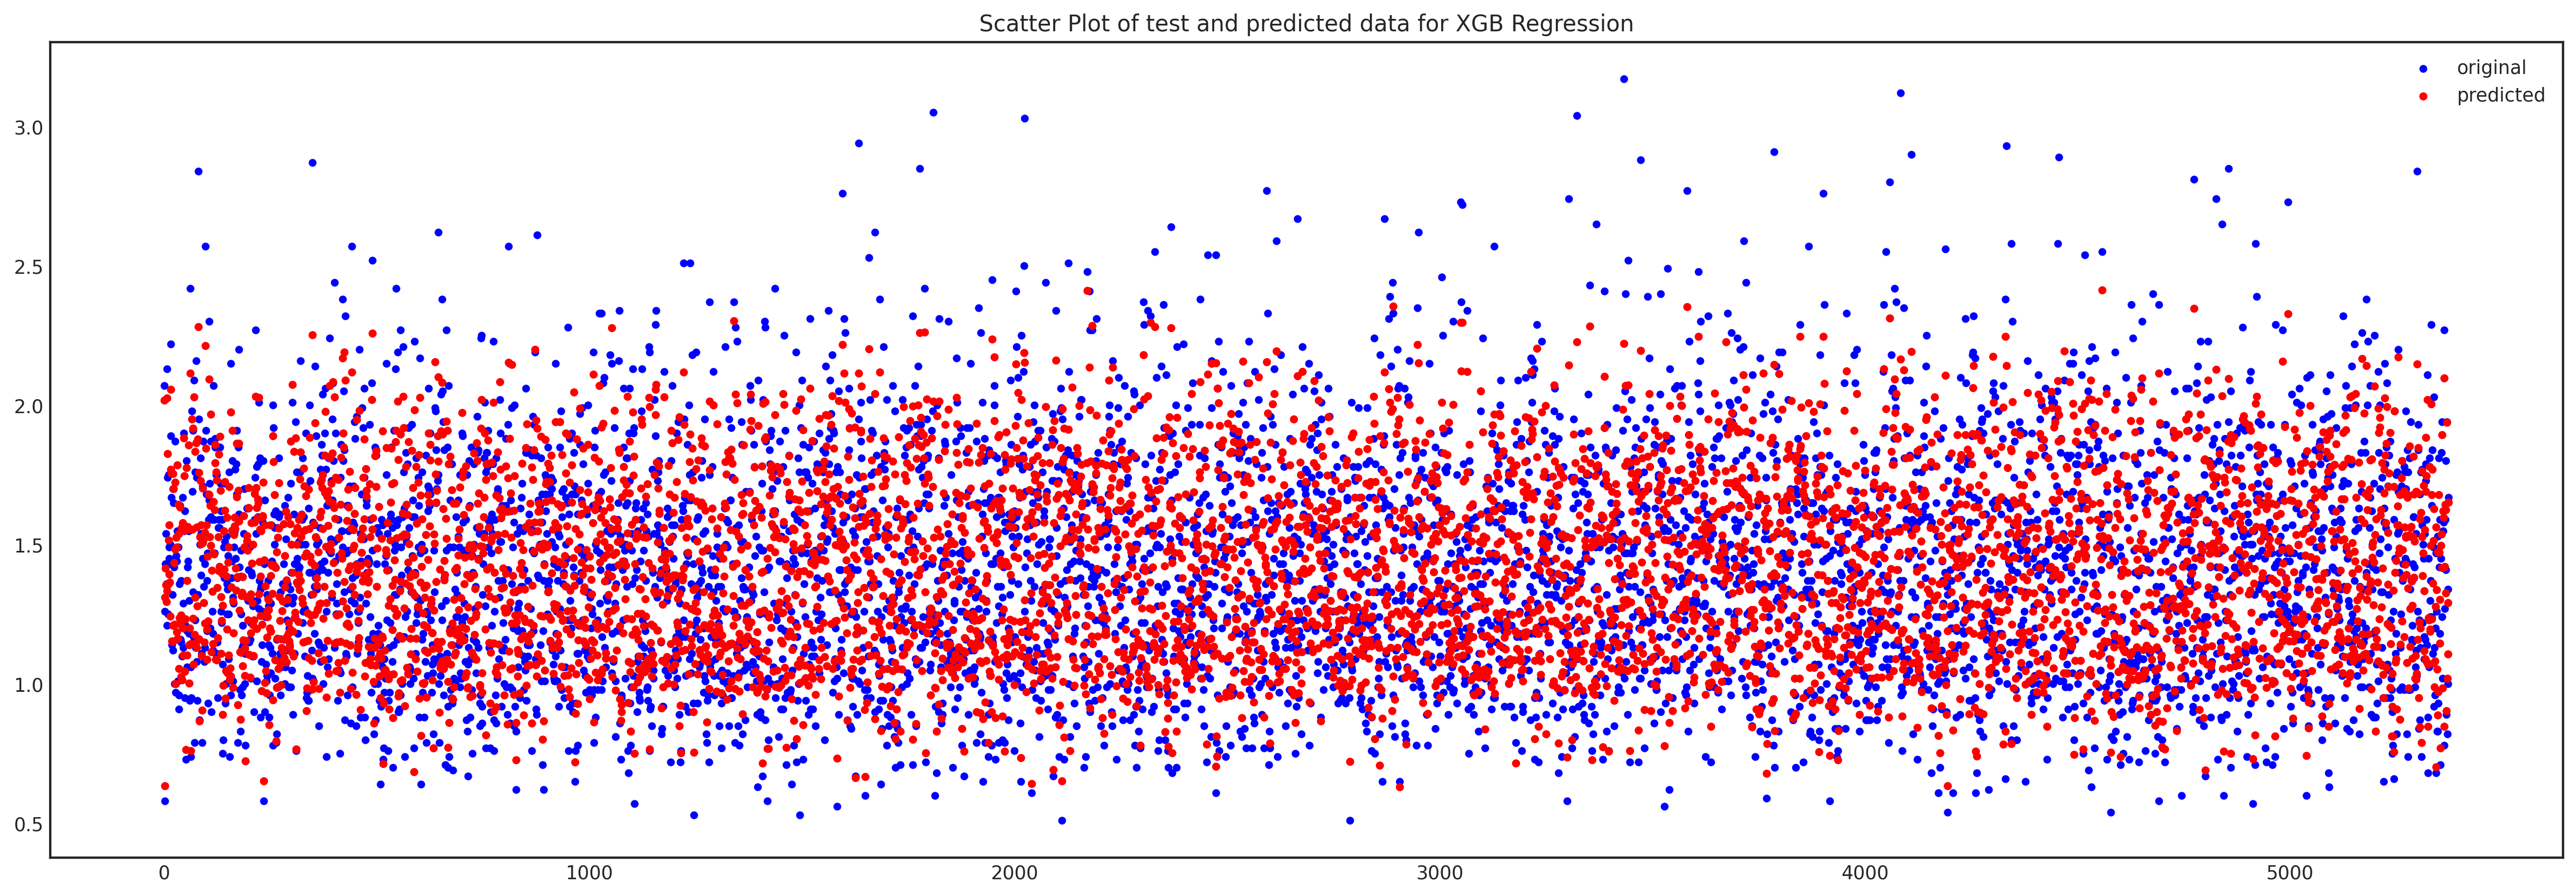

In [ ]:
# Scatter plot for XGB regression
plt.figure(figsize=(24, 8), dpi=250)
y_pred = model.predict(X_test)
plt.scatter(range(len(y_test)), y_test, color="blue", s=10, label="original")
plt.scatter(range(len(y_test)), y_pred, color="red", s=11, label="predicted")
plt.title("Scatter Plot of test and predicted data for XGB Regression")
plt.legend()
plt.show()

#Classfication Model



In [ ]:
le = LabelEncoder()
df['region'] = le.fit_transform(df['region'])
df.head()

Date  AveragePrice  Total Volume  ...      Sales  quarter  type_organic
0 2015-12-27          1.33      64236.62  ...   85433.88        4             0
1 2015-12-20          1.35      54876.98  ...   74082.60        4             0
2 2015-12-13          0.93     118220.22  ...  109944.60        4             0
3 2015-12-06          1.08      78992.15  ...   85311.36        4             0
4 2015-11-29          1.28      51039.60  ...   65329.92        4             0

[5 rows x 16 columns]

In [ ]:
#Creating a new dataframe with few columns only and create train and test data
newdf=df[["AveragePrice","Total Volume","region","type_organic","Total Bags","year"]]

X=newdf[["AveragePrice","Total Volume","region","Total Bags","year"]] #feature columns
y=newdf.type_organic #predictor variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

print("X Train Shape ",X_train.shape)
print("Y Train Shape ",y_train.shape)

print("X Test Shape ",X_test.shape)
print("Y Test Shape ",y_test.shape)

X Train Shape  (14328, 5)
Y Train Shape  (14328,)
X Test Shape  (3583, 5)
Y Test Shape  (3583,)


##Logistic Regression

Accuracy score for Logistic Regression test data is: 0.9260396315936367
Confusion matrix for logistic regression model
              Predicted organic  Predicted Conventional
organic                    1619                     151
Conventional                114                    1699


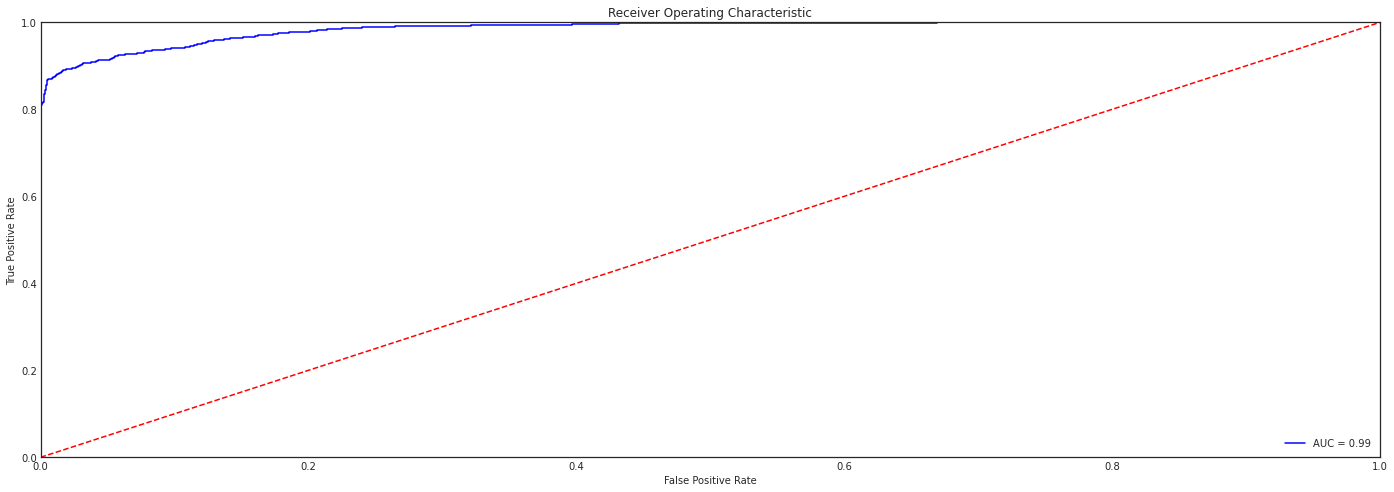

In [ ]:
#Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred_train = logreg.predict(X_train)  
y_pred_test = logreg.predict(X_test)  

#Acuuracy score
print('Accuracy score for Logistic Regression test data is:', accuracy_score(y_test,y_pred_test))


#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test))
confusion_matrix.index = ['organic','Conventional']
confusion_matrix.columns = ['Predicted organic','Predicted Conventional']
print("Confusion matrix for logistic regression model")
print(confusion_matrix)


#AUC ROC Curve
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest Classifier

In [ ]:
#Randomforest classfier
model = RandomForestClassifier(random_state = 0)

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Accuracy score for test data using Random Forest : 0.9921853195646106
Confusion matrix for Random forest model
              Predicted organic  Predicted Conventional
organic                    1767                       3
Conventional                 25                    1788


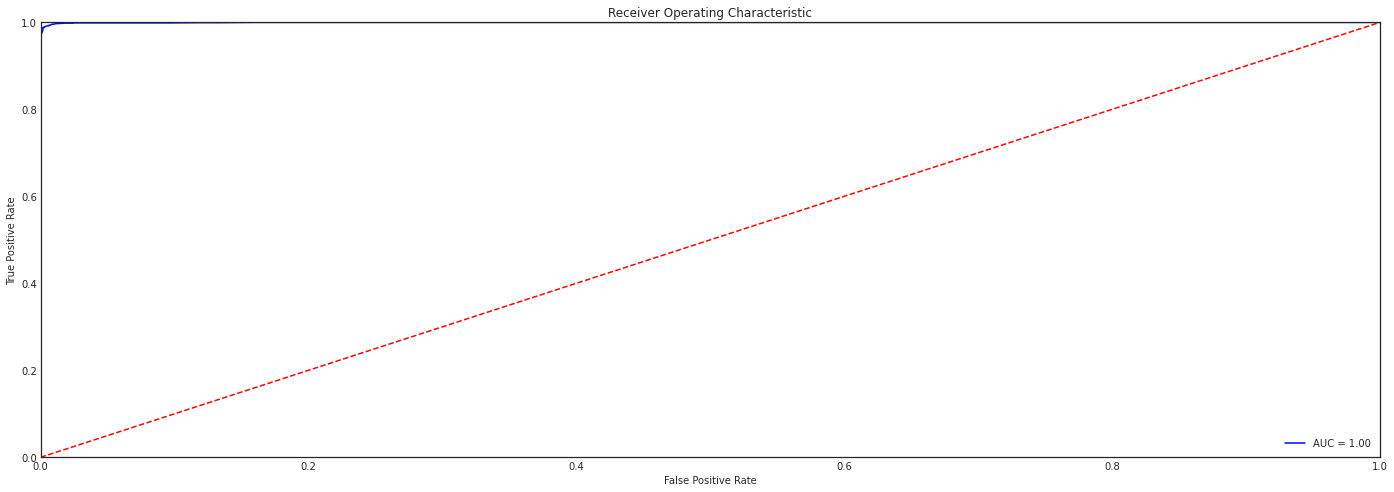

In [ ]:
#Accuracy score
print('Accuracy score for test data using Random Forest :', accuracy_score(y_test,y_pred_test))

#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test))
confusion_matrix.index = ['organic','Conventional']
confusion_matrix.columns = ['Predicted organic','Predicted Conventional']
print("Confusion matrix for Random forest model")
print(confusion_matrix)

#AUC ROC Curve
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Time Series Model


In [ ]:
def getTimeData(df,category):
  dict={'date':[],'AveragePrice':[]}# ,'month':[],'quarter':[],"date":[]
  for i in df.itertuples():
    if(i.type_organic==category):
        #dict["year"].append(i.year)
        dict["AveragePrice"].append(i.AveragePrice)
        dict["date"].append(i.Date)
        #dict["month"].append(i.Month)
        #dict["quarter"].append(i.quarter)
  df2 = pd.DataFrame.from_dict(dict)
  return df2

In [ ]:
df.tail(20)

Date  AveragePrice  Total Volume  ...      Sales  quarter  type_organic
18229 2018-02-25          1.49     301985.61  ...  449957.65        1             1
18230 2018-02-18          1.64     224798.60  ...  368668.72        1             1
18231 2018-02-11          1.47     275248.53  ...  404614.56        1             1
18232 2018-02-04          1.41     283378.47  ...  399562.98        1             1
18233 2018-01-28          1.80     185974.53  ...  334753.20        1             1
18234 2018-01-21          1.83     189317.99  ...  346450.11        1             1
18235 2018-01-14          1.82     207999.67  ...  378558.18        1             1
18236 2018-01-07          1.48     297190.60  ...  439841.20        1             1
18237 2018-03-25          1.62      15303.40  ...   24790.86        1             1
18238 2018-03-18          1.56      15896.38  ...   24797.76        1             1
18239 2018-03-11          1.56      22128.42  ...   34519.68        1             1
18240 2018-03-04          1.54      17393.30  ...   26785.22        1             1
18241 2018-02-25          1.57      18421.24  ...   28920.97        1             1
18242 2018-02-18          1.56      17597.12  ...   27451.32        1             1
18243 2018-02-11          1.57      15986.17  ...   25098.02        1             1
18244 2018-02-04          1.63      17074.83  ...   27830.62        1             1
18245 2018-01-28          1.71      13888.04  ...   23748.48        1             1
18246 2018-01-21          1.87      13766.76  ...   25742.42        1             1
18247 2018-01-14          1.93      16205.22  ...   31275.65        1             1
18248 2018-01-07          1.62      17489.58  ...   28332.18        1             1

[20 rows x 16 columns]

Text(0.5, 1.0, 'Average Price over years for the conventional type')

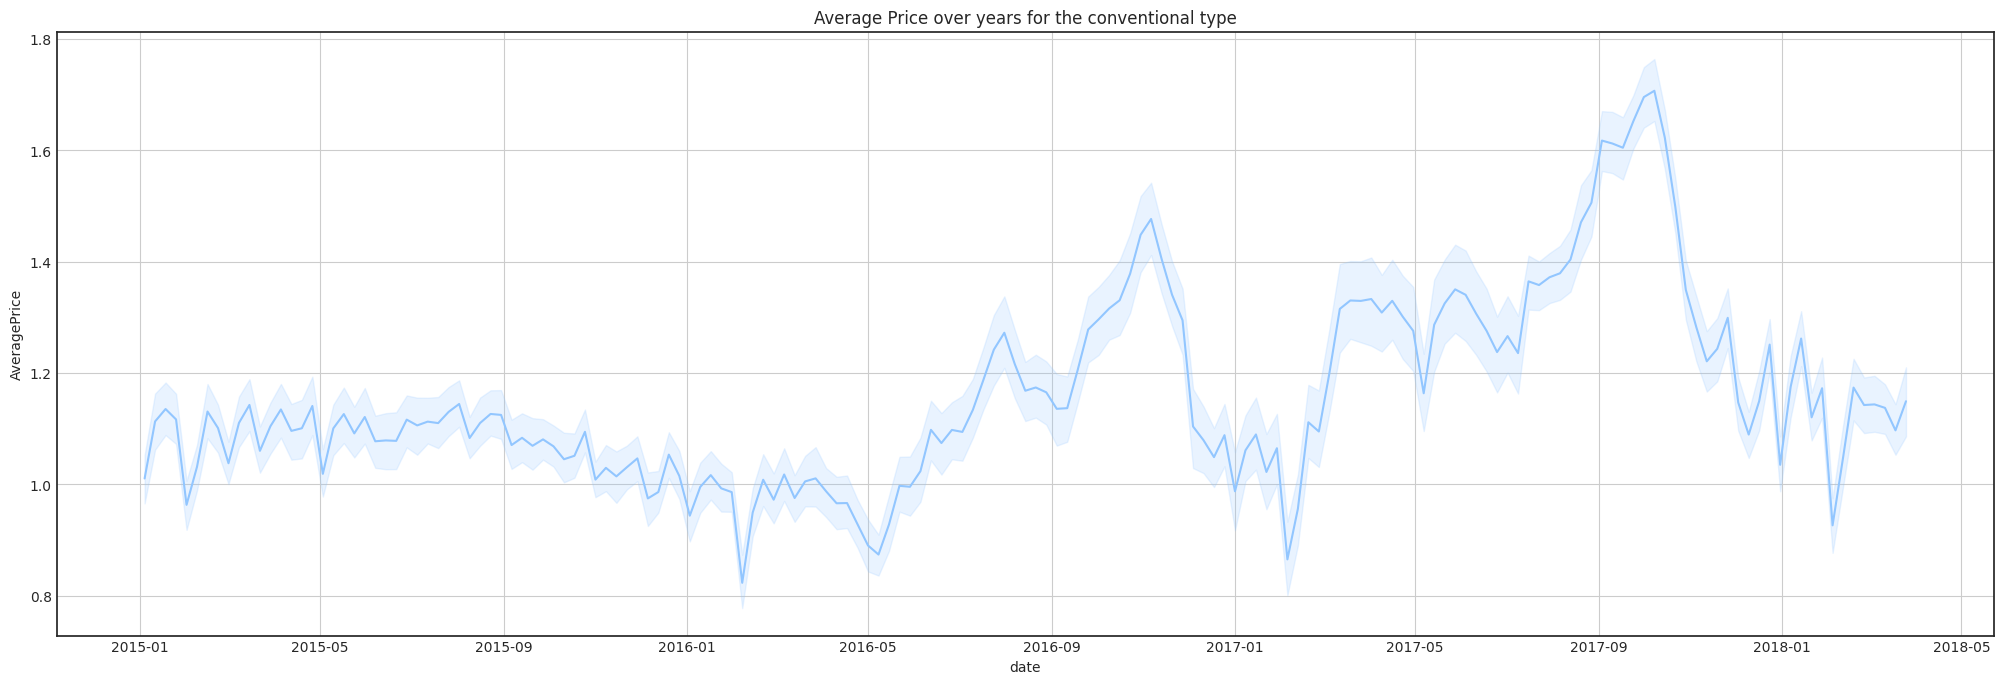

In [ ]:
# Check average price trend by type
df2 = getTimeData(df,0)


plt.figure(figsize = (25,8),dpi=100)
plt.grid()
sns.lineplot(x = 'date', y = 'AveragePrice',data = df2).set_title("Average Price over years for the conventional type")

In [ ]:
#If you do not have pmdarima Installed - colab
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

In [ ]:
df2.index = df2['date']
del df2['date']

In [ ]:
#This takes a few minutes
#SARIMA
smodel = auto_arima(df2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=3,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=14.31 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=-5465.762, Time=1.25 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=-8673.318, Time=5.66 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=-7856.034, Time=5.70 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=-5467.758, Time=0.41 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=-7238.857, Time=1.60 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=-9283.497, Time=8.48 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=26.72 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=22.01 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=-5812.755, Time=2.35 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=-9435.964, Time=15.96 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=-8759.219, Time=7.89 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=29.00 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=19.13 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   : AIC=-

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 8957
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 3)   Log Likelihood                5566.165
Date:                           Tue, 14 Dec 2021   AIC                         -11116.330
Time:                                   18:05:28   BIC                         -11059.531
Sample:                                        0   HQIC                        -11096.997
                                          - 8957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.345e-05   7.06e-05      0.474      0.636      -0.000       0.000
ar.L1          0.2617      0.061      4.308      0.000       0.143       0.381
ar.L2          0.4787      0.043     11.077      0.000       0.394       0.563
ma.L1          0.4047      0.063      6.463      0.000       0.282       0.527
ar.S.L3        0.1767      0.015     11.779      0.000       0.147       0.206
ar.S.L6        0.0505      0.010      4.962      0.000       0.031       0.070
ma.S.L3       -0.9631      0.004   -239.458      0.000      -0.971      -0.955
sigma2         0.0165      0.000     95.035      0.000       0.016       0.017
===================================================================================
Ljung-Box (L1) (Q):                  24.78   Jarque-Bera (JB):              2579.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

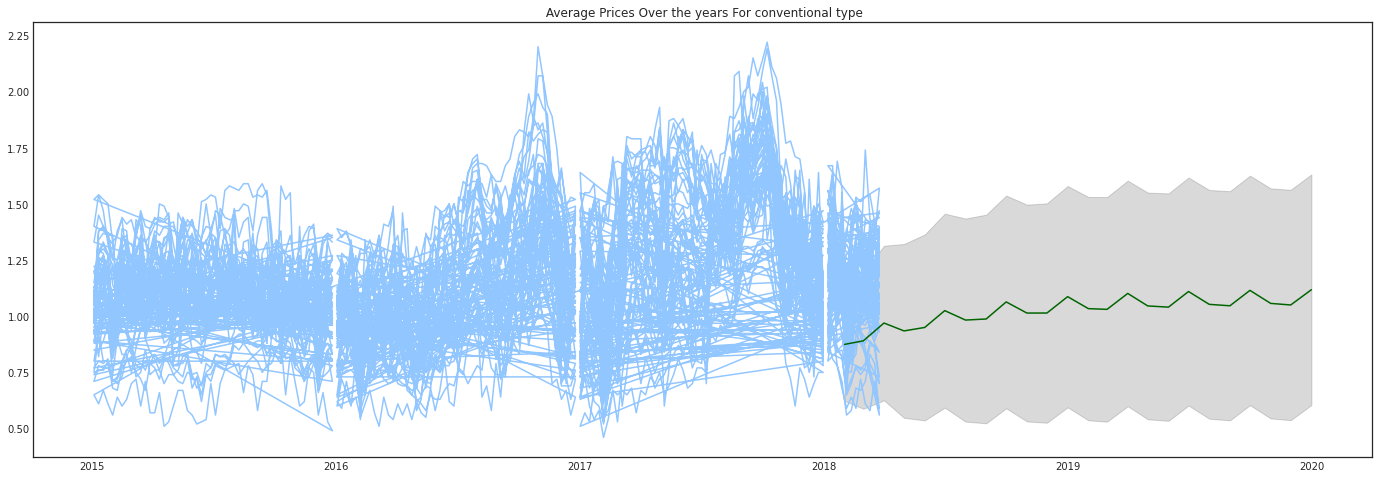

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df2.index[-1], periods = n_periods, freq='MS')


fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)



plt.plot(df2)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title(" Average Prices Over the years For conventional type")
plt.show()

Text(0.5, 1.0, 'Average Price over years for organic type')

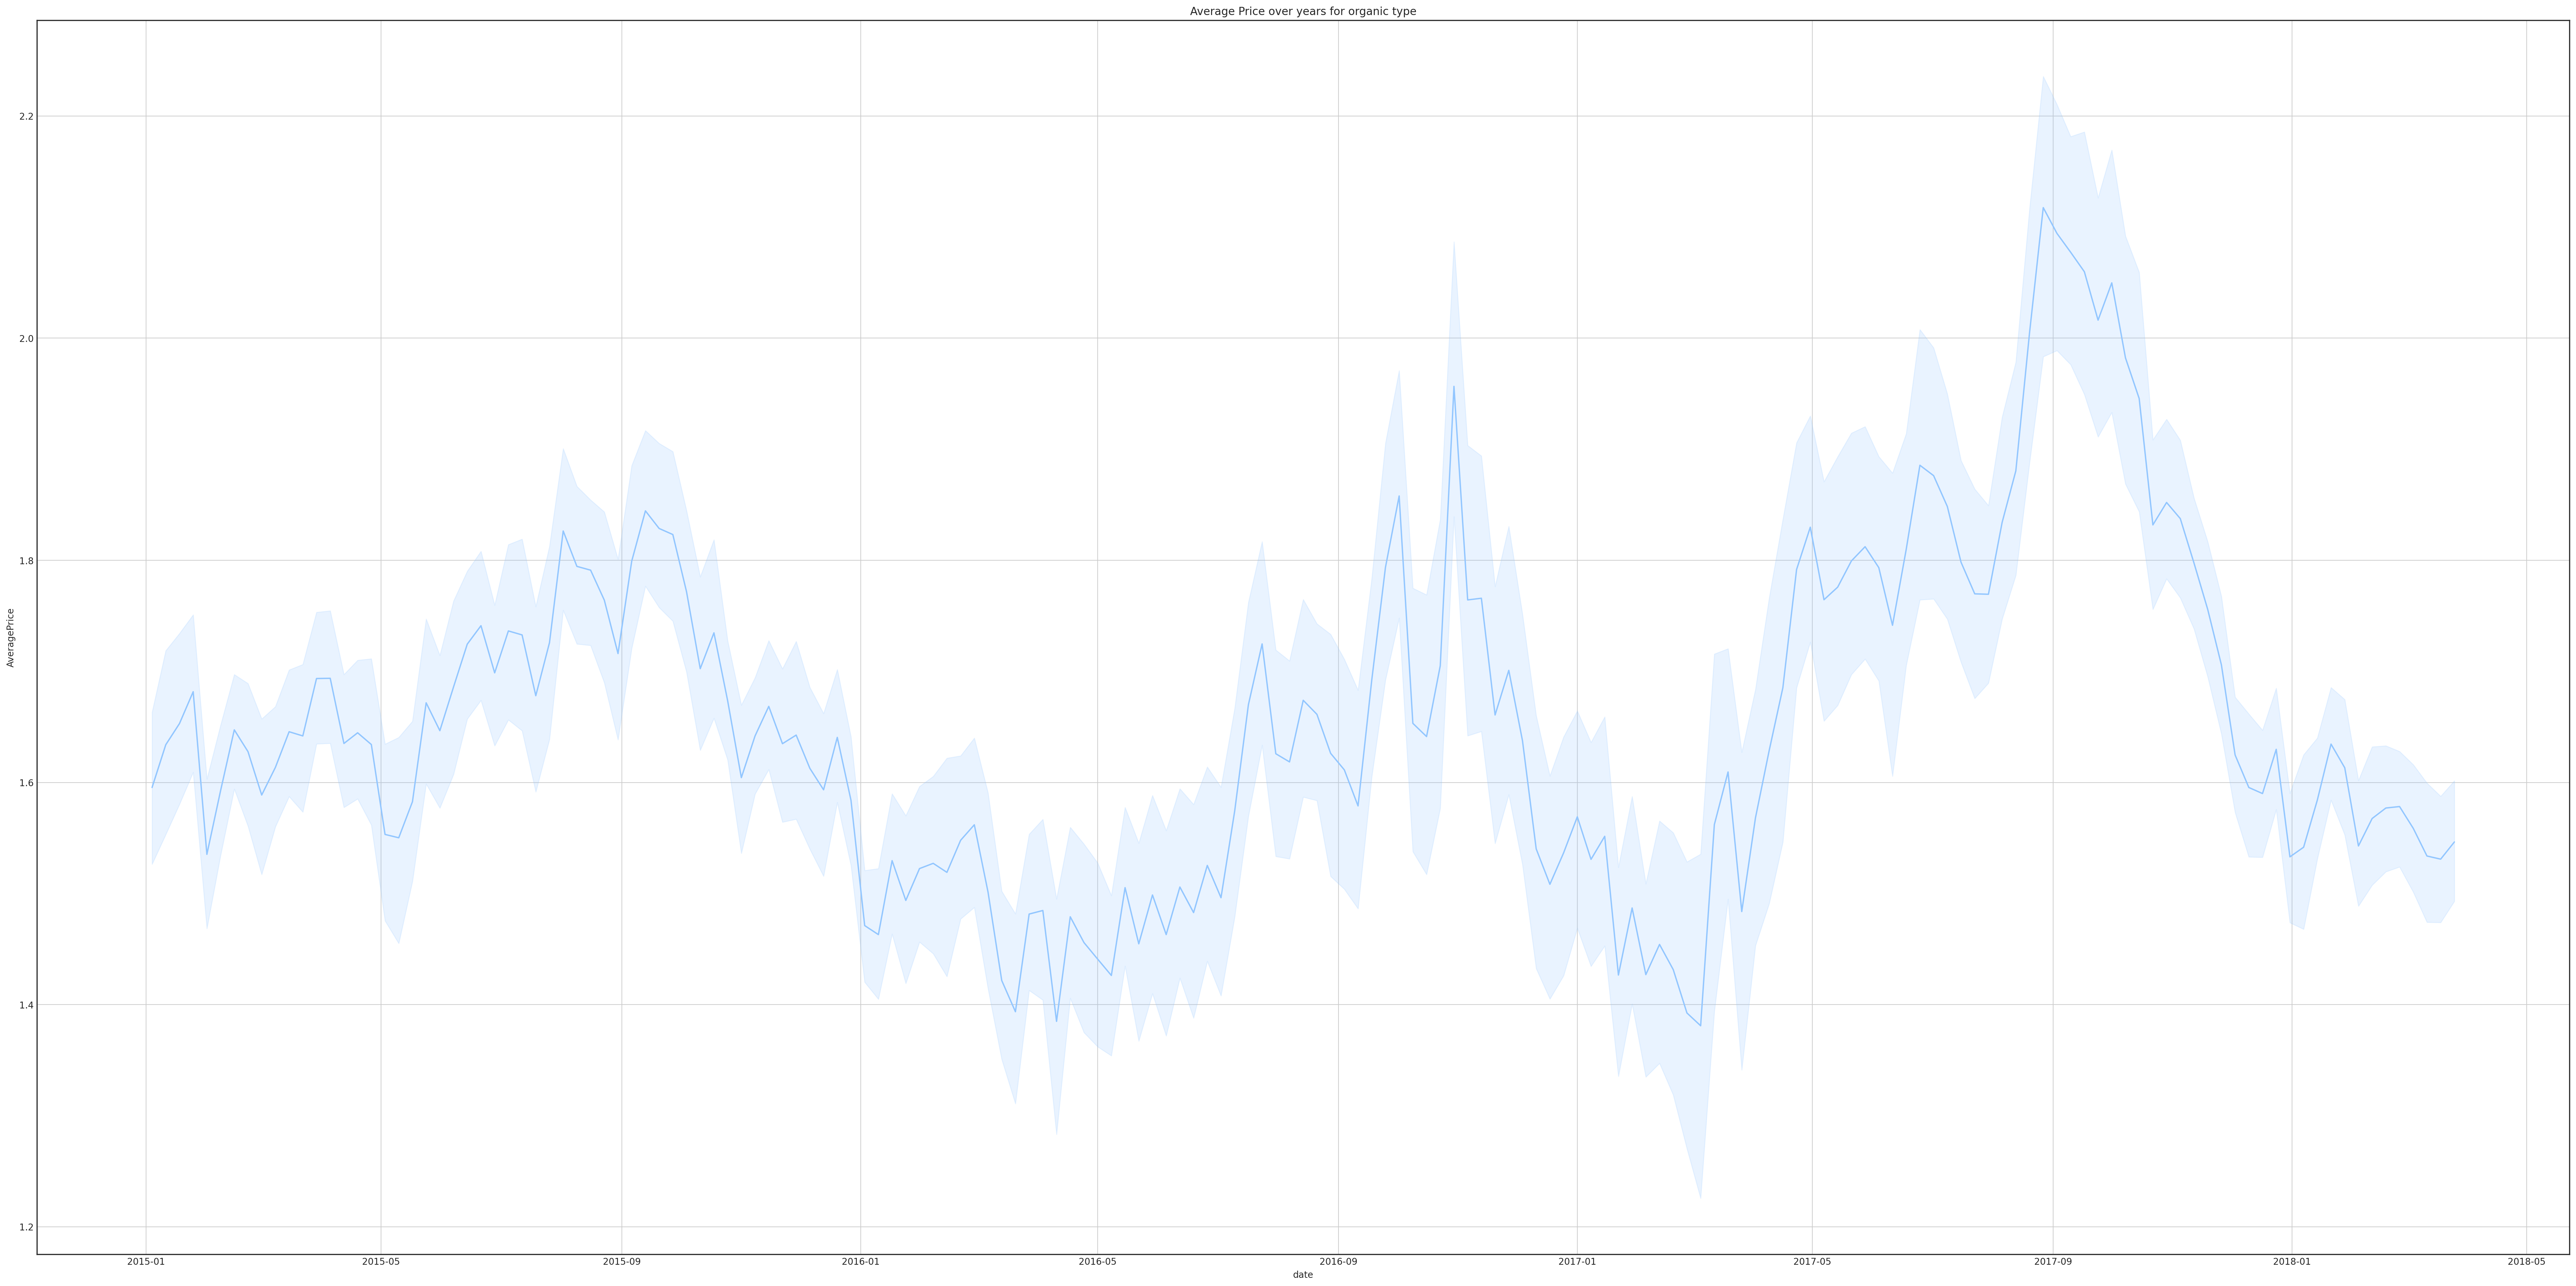

In [ ]:
df3 = getTimeData(df,1)

plt.figure(figsize = (50,25),dpi=200)
plt.grid()
sns.lineplot(x = 'date', y = 'AveragePrice',data = df3).set_title("Average Price over years for organic type")

In [ ]:
df3.index = df3['date']
del df3['date']

In [ ]:
#This takes a few minutes
#SARIMA
smodel1 = auto_arima(df3, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=3,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel1.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=25.77 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=2575.334, Time=0.79 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=-1093.100, Time=4.54 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=-589.815, Time=3.52 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=2573.334, Time=0.41 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=979.085, Time=1.80 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=-1808.090, Time=8.73 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=22.91 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=17.76 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=1690.430, Time=2.60 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=-1859.999, Time=12.89 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=-1093.938, Time=6.56 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=32.63 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=18.86 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   : AIC=-1952.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8954
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 3)   Log Likelihood                 983.489
Date:                            Tue, 14 Dec 2021   AIC                          -1954.979
Time:                                    18:12:39   BIC                          -1912.382
Sample:                                         0   HQIC                         -1940.480
                                           - 8954                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2452      0.018    -13.732      0.000      -0.280      -0.210
ar.L2          0.5796      0.011     52.167      0.000       0.558       0.601
ma.L1          0.8233      0.019     42.739      0.000       0.786       0.861
ar.S.L3       -0.5908      0.008    -70.472      0.000      -0.607      -0.574
ar.S.L6       -0.3138      0.008    -37.143      0.000      -0.330      -0.297
sigma2         0.0470      0.000    106.679      0.000       0.046       0.048
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):              4275.78
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

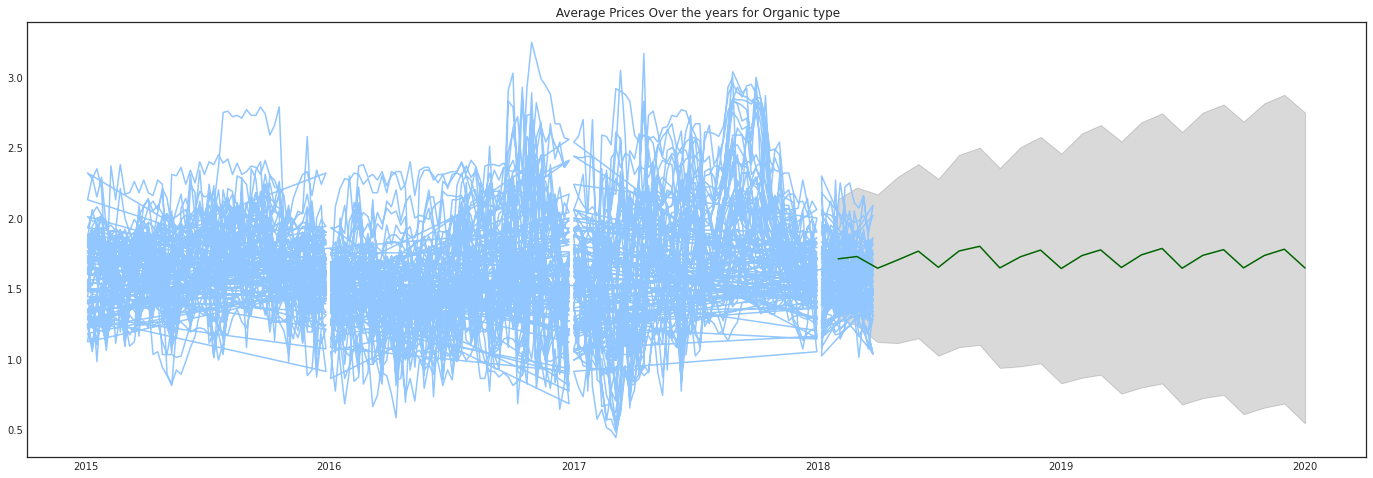

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df3.index[-1], periods = n_periods, freq='MS')


fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)



plt.plot(df3)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title(" Average Prices Over the years for Organic type")
plt.show()

in the future, we can check overfitting issue, especially on random forest classifier. Train the data 